# Reflection Analytics

Time Period: **Week 1 (Jan 8 - 12)**

This notebook is based on the csv extracted from Quercus from individual "Reflections" pages, by clicking on the "Student Analysis" tab. All student personal data has been removed, and the notebook only deals with aggregated groups (i.e. lecture assigned, engineering discipline). The results are based on the students who have completed a reflection for this week.

## Data Sources
General sources (kept between weeks in `class_data` folder):
- `ClassList-20231-APS106H1-S.csv`: sheet from department
- `vader_lexicon.txt`: used for sentiment analysis

## Summary of Analysis
This notebook is broken into the following sub-sections:
1. Student Attendance
2. Previous Expience with Programming
3. Comfort with Topics 
4. Most Confusing Topics
5. Sentiment Analysis

# Define Imports

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly
import matplotlib

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

import warnings
warnings.filterwarnings('ignore')

# plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")

# Initialize Global Variables

In [2]:
week = 1

lecture_name = {
    "LEC0101": "Kinsella & Goodfellow",
    "LEC0102": "Moosavi",
    "LEC0103": "Beck"
}

lecture = [
         'Lecture 1',
         'Lecture 2',
         'Lecture 3']

lectures = [
            'Kinsella & Goodfellow', 
            'Moosavi', 
            'Beck']

section = ['LEC0101','LEC0102','LEC0103']

disciplines = [
    'Mechanical',
    'Industrial',
    'Materials',
    'Chemical',
    'Non-Degree',
    'Track-One',
    'Mineral',
    'Civil'
]

plt.style.use('fivethirtyeight')
colors = ['#ADD8E6','#ffcc99','#98AFC7','#ff9999','#d7edb9','#c4bcc0','#67805c','#ab446c','#41734f','#eb4034']

# Read in Data

In [3]:
# Student Data
student_data_path = "../class_data/ClassList-20241-APS106H1-S.csv" 
students_df = pd.read_csv(student_data_path)

# Reflection Data
reflection_path = "week" + str(week) + "_raw.csv"
reflections_df = pd.read_csv(reflection_path)

# Preprocessing Data

In [4]:
# Remove column names up to the outputted number
reflections_df.columns[-4]

'1.0.16'

In [5]:
# 1 -data cleansing. Remove the "attempt" and question score columns auto-generated by quercus
reflections_df = reflections_df.drop(columns=['attempt','1.0', '1.0.1','1.0.2','1.0.3','1.0.4',
        '1.0.4','1.0.5','1.0.6','1.0.7','1.0.8','1.0.9','1.0.10', 
        '1.0.11', '1.0.12', '1.0.13', '1.0.14', '1.0.15', '1.0.16',  'n correct', 'n incorrect', 'score'])

# 2 - rename columns in dataframe so are shorter
current_column_names = list(reflections_df.columns)

column_names = {
    current_column_names[7]: "lecture_sections",
    current_column_names[8]: "lecture_reasons",
    current_column_names[9]: "lecture_alternate_section",
    current_column_names[10]: "hybrid_learning",
    current_column_names[11]: "video_materials",
    current_column_names[12]: "practice_problems", 
    current_column_names[13]: "progress_check",   
    current_column_names[14]: "comment_one_word",  
    current_column_names[15]: "confused_topics",
    current_column_names[16]: "previous_exp",
    current_column_names[17]: "aps106_future_use",
    current_column_names[18]: "coding_future",
    current_column_names[19]: "python_setup",
    current_column_names[20]: "languages",
    current_column_names[21]: "variable_check",
    current_column_names[22]: "expression_check",
    current_column_names[23]: "operator_check",
}

reflections_df.rename(columns=column_names, inplace=True)

# 3 - join reflection data with student data based on UTORid 
combined_df = reflections_df.merge(students_df, left_on = "sis_id", right_on = "UTORid", how="left")

# 4 - rename disciplines from the POSt Code 
combined_df['POSt Code'] = combined_df['POSt Code'].str.rstrip("X")

disciplines = {
    "AECHEBASC": "Chemical",
    "AECIVBASC": "Civil",
    "AEMECBASC": "Mechanical",
    "AELMEBASC": "Mineral",
    "AEINDBASC": "Industrial",
    "AEMMSBASC": "Materials",
    "AEENGBASC": "Track-One", 
    "AE   NDEGI": "Non-Degree"
    }

combined_df['discipline'] = combined_df['POSt Code'].map(disciplines)  #'Person ID',
combined_df = combined_df.drop(columns = ['Session Code','Activity Code','Section Code',
                                         'POSt Code','Surname','Given Name',
                                          'Year','Email Address','UTORid','name','id','sis_id'])
# combined_df = combined_df.drop(columns=['sis_id','UTORid','name', 'Surname', 'Given Name',
#        'Title', 'Year', 'Reg. Sts', 'Enr. Sts','Email Address','id' ])

# temporary rename of dataframe!
# combined_df = reflections_df

# 5 - get count of lecture sections attended + reformat to match student information sheet
combined_df['LEC0101_attended'] = np.where(combined_df['lecture_sections'].str.contains("LEC0101"), "LEC0101", False)
combined_df['LEC0102_attended'] = np.where(combined_df['lecture_sections'].str.contains("LEC0102"), "LEC0102", False)
combined_df['LEC0103_attended'] = np.where(combined_df['lecture_sections'].str.contains("LEC0103"), "LEC0103", False)

combined_df['lecture_assigned'] = np.where(np.logical_or(combined_df['LEC0103_attended'] == combined_df['Lecture'], np.logical_or(combined_df['LEC0101_attended'] == combined_df['Lecture'],
            combined_df['LEC0102_attended'] == combined_df['Lecture'])), True, False) # does not account for students not in excel!


### ADD POLARITY TO LONG ANSWERS ###

# 1 - remove all punctuation from student paragraph, lower all strings
punctuations = '!"#$%&\'()*+,-./:;<=>?@@[\\]^_`{|}~“' 
esc_char = "\xa0"

def remove_punctuations(text):
    text = str(text)
    for x in punctuations:
        if (x in text):
            text=text.replace(x," ")
    return text

combined_df['cleaned_answer'] = combined_df.apply(lambda row: remove_punctuations(text=row['comment_one_word']),axis=1)
combined_df['cleaned_answer'] = combined_df['cleaned_answer'].str.lower()

# 2 - each word from the reflection will be separated into its own row in a new dataframe
word_lookup = (combined_df['cleaned_answer'].str.split(' ', expand=True).stack().reset_index(name='word'))
word_lookup = word_lookup[word_lookup.word != '']
word_lookup = word_lookup.set_index('level_0',drop=True).rename(columns={'level_1':'num'})


# 3 - introduce lexicon to look up polarity values for each word 
file = open('../class_data/vader_lexicon.txt', 'r').read().split('\n')
lexicon_text = [x for x in file[0:]]

lexicon =  pd.DataFrame(lexicon_text,columns=['data'])
lexicon = lexicon['data'].str.split('\t',expand=True)
lexicon = lexicon[[0,1]].rename(columns={0: "word", 1: "polarity"}).set_index('word')

# 4 - look up each word inside the long answer, assign a polarity
word_lookup = word_lookup.join(lexicon, on ='word')
word_lookup.fillna(0, inplace=True)

# 5 - aggregate dataframe back to sum polarity per long answer
word_lookup[["polarity"]] = word_lookup[["polarity"]].apply(pd.to_numeric)
polarity = word_lookup.groupby(['level_0'])['polarity'].sum().to_frame()

# 6 - join polarity data back into combined_df
combined_df = combined_df.join(polarity)
combined_df['lecture_count'] = combined_df['lecture_sections'].str.count('\\\\')

# export cleaned dataframe into csv
combined_df.to_csv('reflection{}.csv'.format(week))

combined_df.head()

section              section_id  \
0  APS106H1-S-TUT0107-20241, APS106H1-S-LEC0103-2...  320323, 320149, 320262   
1  APS106H1-S-PRA0102-20241, APS106H1-S-LEC0101-2...  320224, 320111, 320285   
2  APS106H1-S-PRA0103-20241, APS106H1-S-TUT0108-2...  320231, 320328, 320111   
3  APS106H1-S-LEC0101-20241, APS106H1-S-TUT0103-2...  320111, 320294, 320270   
4  APS106H1-S-LEC0103-20241, APS106H1-S-TUT0108-2...  320149, 320328, 320270   

                                      section_sis_id                submitted  \
0  APS106H1-S-TUT0107-20241, APS106H1-S-LEC0103-2...  2024-01-15 06:00:00 UTC   
1  APS106H1-S-PRA0102-20241, APS106H1-S-LEC0101-2...  2024-01-15 05:57:08 UTC   
2  APS106H1-S-PRA0103-20241, APS106H1-S-TUT0108-2...  2024-01-15 05:55:41 UTC   
3  APS106H1-S-LEC0101-20241, APS106H1-S-TUT0103-2...  2024-01-15 05:50:50 UTC   
4  APS106H1-S-LEC0103-20241, APS106H1-S-TUT0108-2...  2024-01-15 05:29:00 UTC   

                                    lecture_sections  \
0  Beck (LEC0103) - Lecture 1 (Monday\, 3 - 4 pm)...   
1  Kinsella & Goodfellow (LEC0101) - Lecture 2 (T...   
2  Kinsella & Goodfellow (LEC0101) - Lecture 1 (T...   
3  Kinsella & Goodfellow (LEC0101) - Lecture 1 (T...   
4  Beck (LEC0103) - Lecture 1 (Monday\, 3 - 4 pm)...   

                                     lecture_reasons  \
0     I was studying for a term test for this course   
1  The lectures are not an effective learning too...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

  lecture_alternate_section  \
0                     Other   
1                       NaN   
2                       NaN   
3                       NaN   
4                       NaN   

                                     hybrid_learning  \
0      Coding along with the instructor on my device   
1  Following the lecture by looking at the conten...   
2  Following the lecture by looking at the conten...   
3  Following the lecture by looking at the conten...   
4  Following the lecture by looking at the conten...   

                                     video_materials practice_problems  ...  \
0  LEC0102 - Moosavi Lecture Recording,LEC0103 - ...                No  ...   
1  LEC0101 - Kinsella & Goodfellow Lecture Recording                No  ...   
2                                               None                No  ...   
3  LEC0101 - Kinsella & Goodfellow Lecture Recording                No  ...   
4                                               None                No  ...   

  Tutorial Practical  discipline LEC0101_attended LEC0102_attended  \
0  TUT0107   PRA0107  Industrial            False            False   
1  TUT0102   PRA0102    Chemical          LEC0101            False   
2  TUT0108   PRA0103  Mechanical          LEC0101            False   
3      NaN       NaN         NaN          LEC0101            False   
4  TUT0108   PRA0108   Materials            False            False   

  LEC0103_attended lecture_assigned  \
0          LEC0103             True   
1            False             True   
2            False             True   
3            False            False   
4          LEC0103             True   

                                      cleaned_answer polarity lecture_count  
0                                               good      1.9           3.0  
1                                                nan      0.0           2.0  
2                                            excited      1.4           3.0  
3  i feel that is a course that will start becomi...      0.3           3.0  
4                                          competent      1.3           3.0  

[5 rows x 33 columns]

In [6]:
# plt.style.use('fivethirtyeight')
week = 1

# Number of students who completed reflection

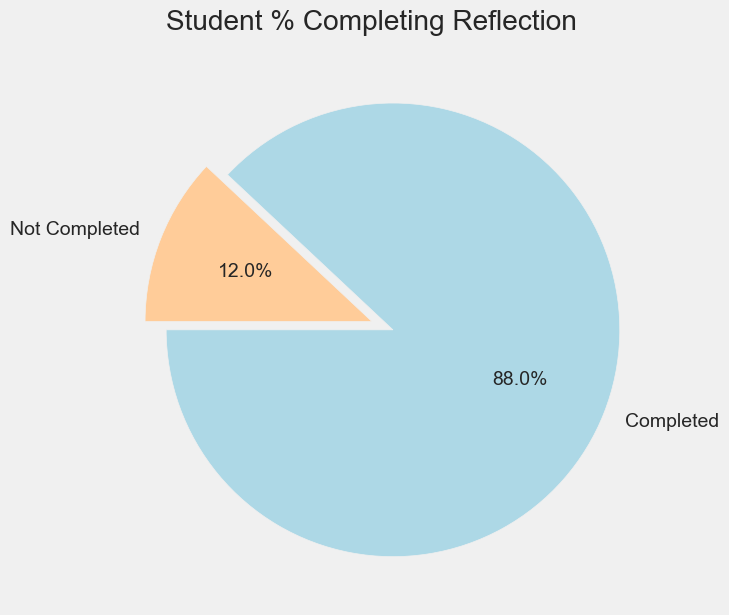

In [7]:
completed = len(reflections_df)
not_complete = len(students_df) - completed

plt.figure(figsize=(7,7)) 
plt.title("Student % Completing Reflection")

values = [completed, not_complete]
name = ["Completed", "Not Completed"]

explode = (0.1, 0)

plt.pie(values, labels=name, colors=colors, startangle=-180,autopct='%1.1f%%',explode=explode)
plt.show()

# Student Attendence During Current Week

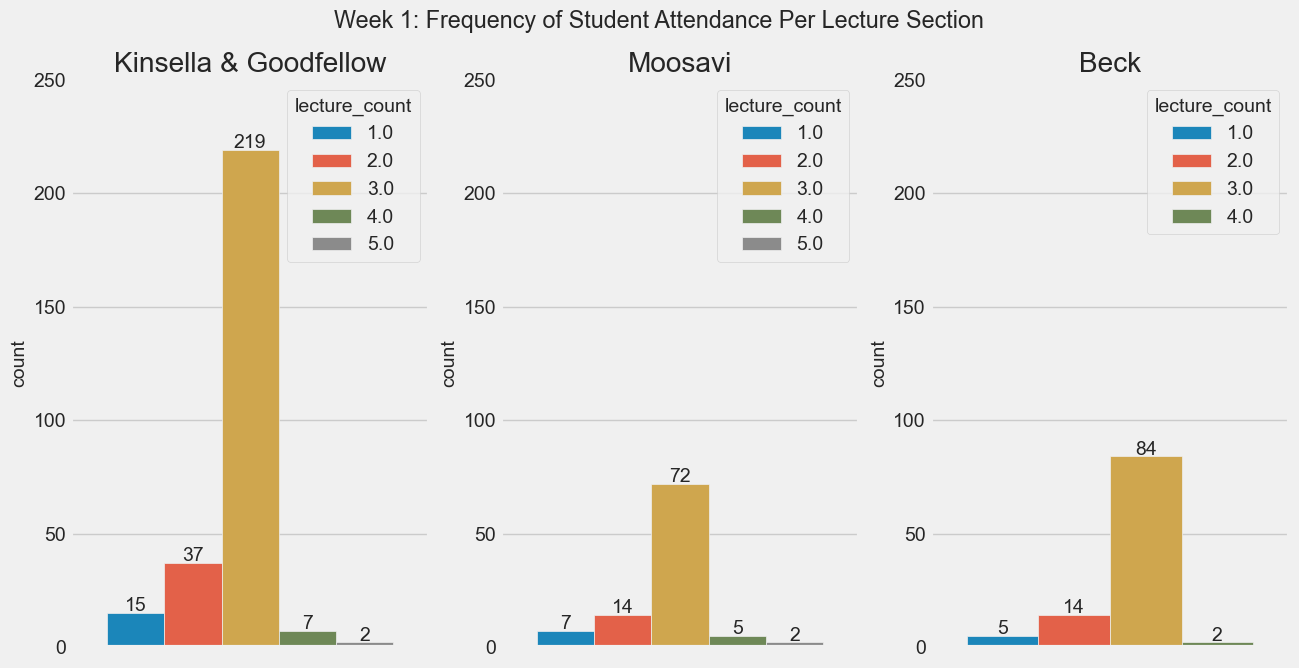

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(14, 7))

fig.suptitle("Week {}: Frequency of Student Attendance Per Lecture Section".format(week))

column_list = ["LEC0101_attended","LEC0102_attended","LEC0103_attended"]
lecture_list = [ x.split('_')[0] for x in column_list]

for index, value in enumerate(column_list):
    data = combined_df[combined_df[value]==lecture_list[index]]
    sns.countplot(x=value, hue="lecture_count", data=data, ax=axs[index])
    axs[index].get_xaxis().set_visible(False)
    axs[index].set_ylim(0,250)
    axs[index].set_title(lecture_name[lecture_list[index]])

    for i, p in enumerate(axs[index].patches):
        axs[index].annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')


plt.show()

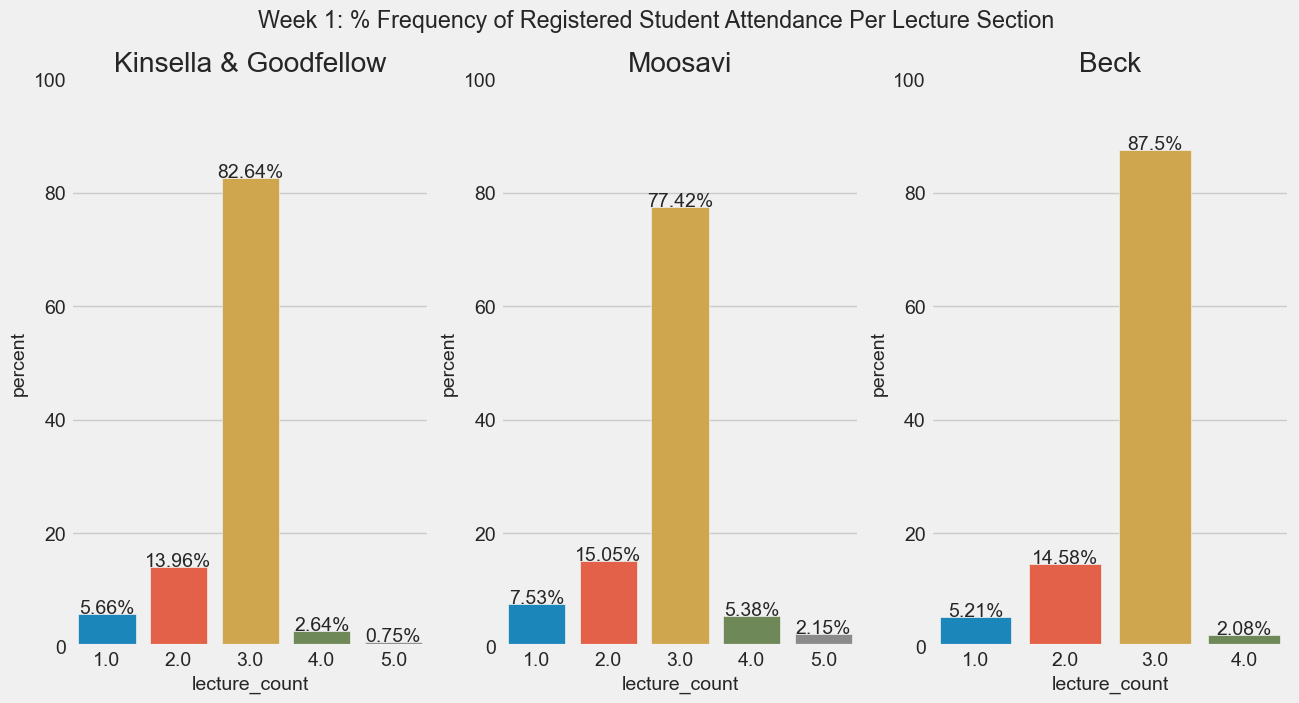

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(14, 7))

fig.suptitle("Week {}: % Frequency of Registered Student Attendance Per Lecture Section ".format(week))

column_list = ["LEC0101_attended","LEC0102_attended","LEC0103_attended"]
lecture_list = [ x.split('_')[0] for x in column_list]

assigned_lecture = [
    len(combined_df[combined_df["Lecture"]=="LEC0101"]),
    len(combined_df[combined_df["Lecture"]=="LEC0102"]),
    len(combined_df[combined_df["Lecture"]=="LEC0103"])
]

for index, value in enumerate(column_list):

    #filter down the dataframe only to the specific lecturer
    df_temp = combined_df[combined_df[value]==lecture_list[index]]
    df_temp = df_temp.groupby("lecture_count").agg('count')

    df_temp =  df_temp[["section"]].copy().reset_index()
    df_temp['percent'] = df_temp['section'] / assigned_lecture[index] * 100


    sns.barplot(data=df_temp, x="lecture_count", y="percent", ax=axs[index])
    axs[index].set_ylim(0,100)
    axs[index].set_title(lecture_name[lecture_list[index]])

    values = list(df_temp['percent'])

    for i, p in enumerate(axs[index].patches):
        height = p.get_height()
        axs[index].text(p.get_x()+p.get_width()/2., height + 0.1,"{}%".format(round((values[i]),2)),ha="center")

plt.show()

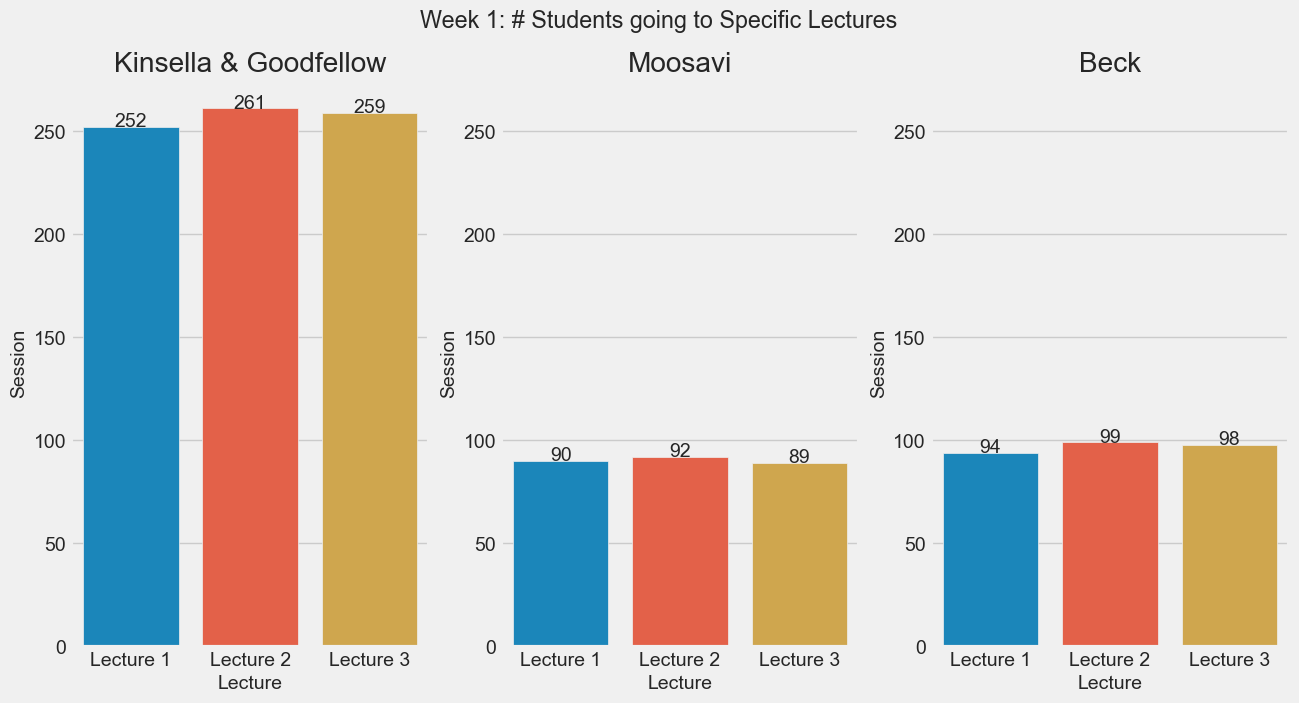

In [10]:
# figure out which specific sections students are going to 
fig, axs = plt.subplots(1, 3, figsize=(14, 7))

fig.suptitle("Week {}: # Students going to Specific Lectures".format(week))

for index, lec in enumerate(lectures):
    
    session_count = []

    # define a count for each individual session
    for session in lecture:
        count = combined_df['lecture_sections'].str.contains(session) & combined_df['lecture_sections'].str.contains(lectures[index])
        count = count.sum()
        session_count.append(count)

    # convert list to dataframe
    df = pd.DataFrame({'Lecture': lecture, 
                       'Session': session_count})

    # create the barplot
    sns.barplot(x='Lecture', y='Session', data=df, ax=axs[index])
    axs[index].set_ylim(0,275)
    axs[index].set_title(lecture_name[lecture_list[index]])

    values = list(df['Session'])

    for i, p in enumerate(axs[index].patches):
        height = p.get_height()
        axs[index].text(p.get_x()+p.get_width()/2., height + 0.1,"{}".format(round((values[i]),2)),ha="center")

plt.show()

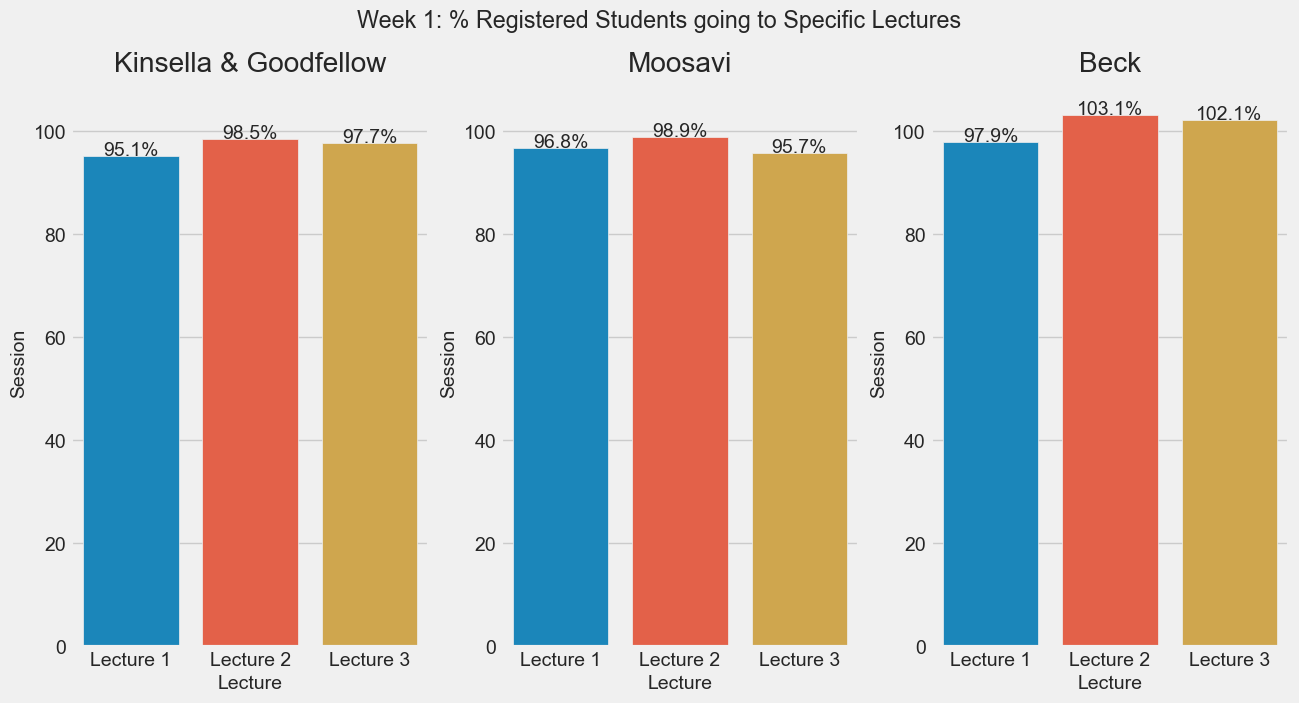

In [11]:
# figure out which specific sections students are going to 
fig, axs = plt.subplots(1, 3, figsize=(14, 7))

fig.suptitle("Week {}: % Registered Students going to Specific Lectures".format(week))

# number students registered per section
combined_df = combined_df.sort_values(by='Lecture')

for index, lec in enumerate(lectures):
    
    session_count = []

    # define a count for each individual session
    for session in lecture:
        count = combined_df['lecture_sections'].str.contains(session) & combined_df['lecture_sections'].str.contains(lectures[index])
        count = count.sum()
        session_count.append(count)

    # total number students registered in section
    registered = combined_df['Lecture'].str.contains(section[index]).sum()

    # update session count to be a percent
    session_count = [x/registered*100 for x in session_count]

    # convert list to dataframe
    df = pd.DataFrame({'Lecture': lecture, 
                       'Session': session_count})

    # create the barplot
    sns.barplot(x='Lecture', y='Session', data=df, ax=axs[index])
    axs[index].set_ylim(0,110)
    axs[index].set_title(lecture_name[lecture_list[index]])

    values = list(df['Session'])

    for i, p in enumerate(axs[index].patches):
        height = p.get_height()
        axs[index].text(p.get_x()+p.get_width()/2., height + 0.1,"{}%".format(round((values[i]),1)),ha="center")

plt.show()

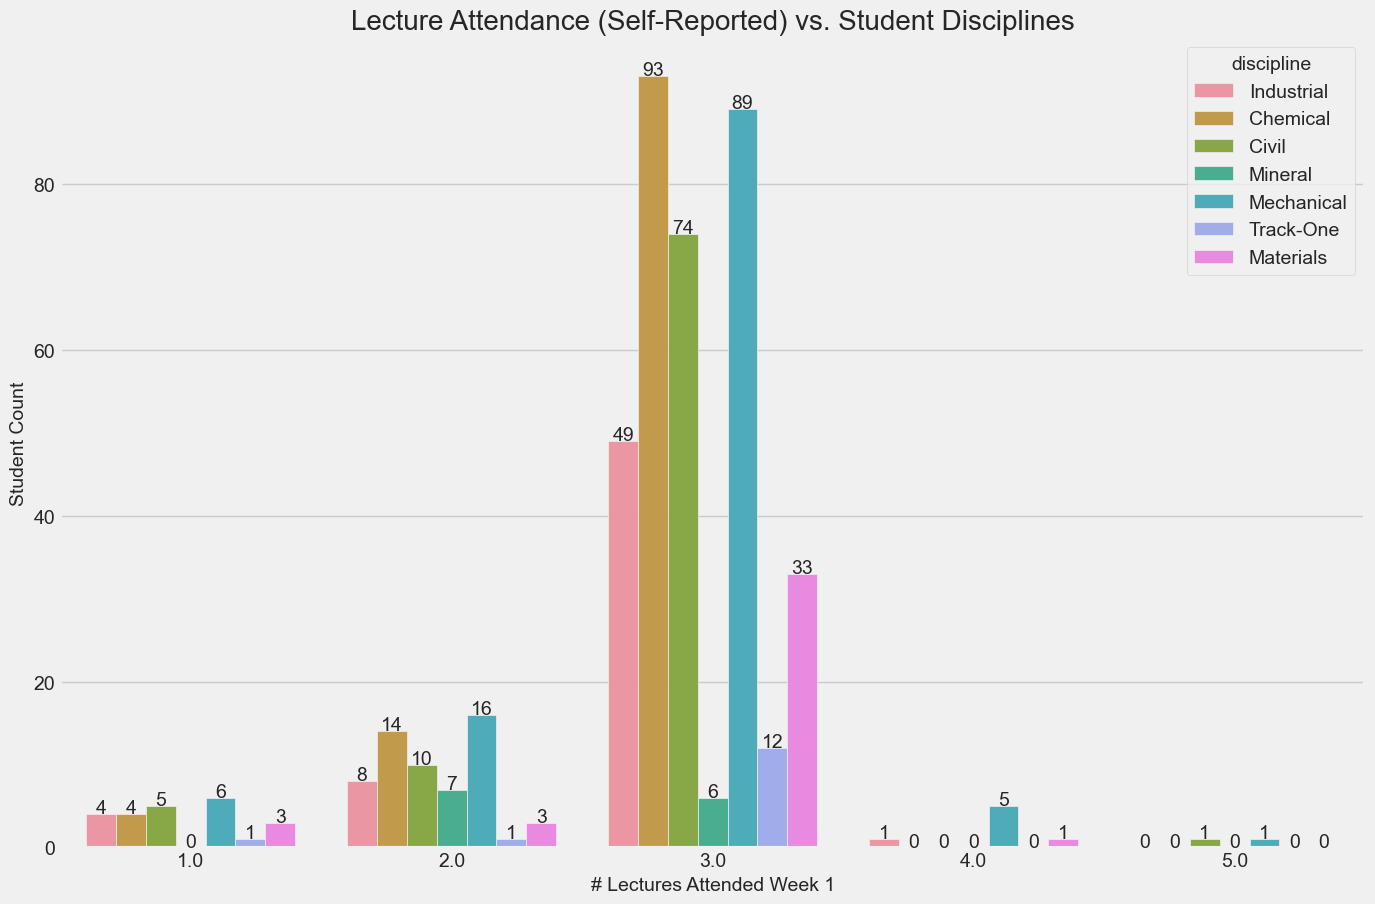

In [12]:
plt.figure(figsize=(15,10)) 
plt.title('Lecture Attendance (Self-Reported) vs. Student Disciplines', fontsize = 20)
ax = sns.countplot(x="lecture_count", hue="discipline", data=combined_df[combined_df['lecture_count']!=0]) 

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,"{}".format(str(p).split(',')[3].split('=')[1]),ha="center")

ax.set_ylabel('Student Count', fontsize=14)
ax.set_xlabel('# Lectures Attended Week 1', fontsize=14)
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


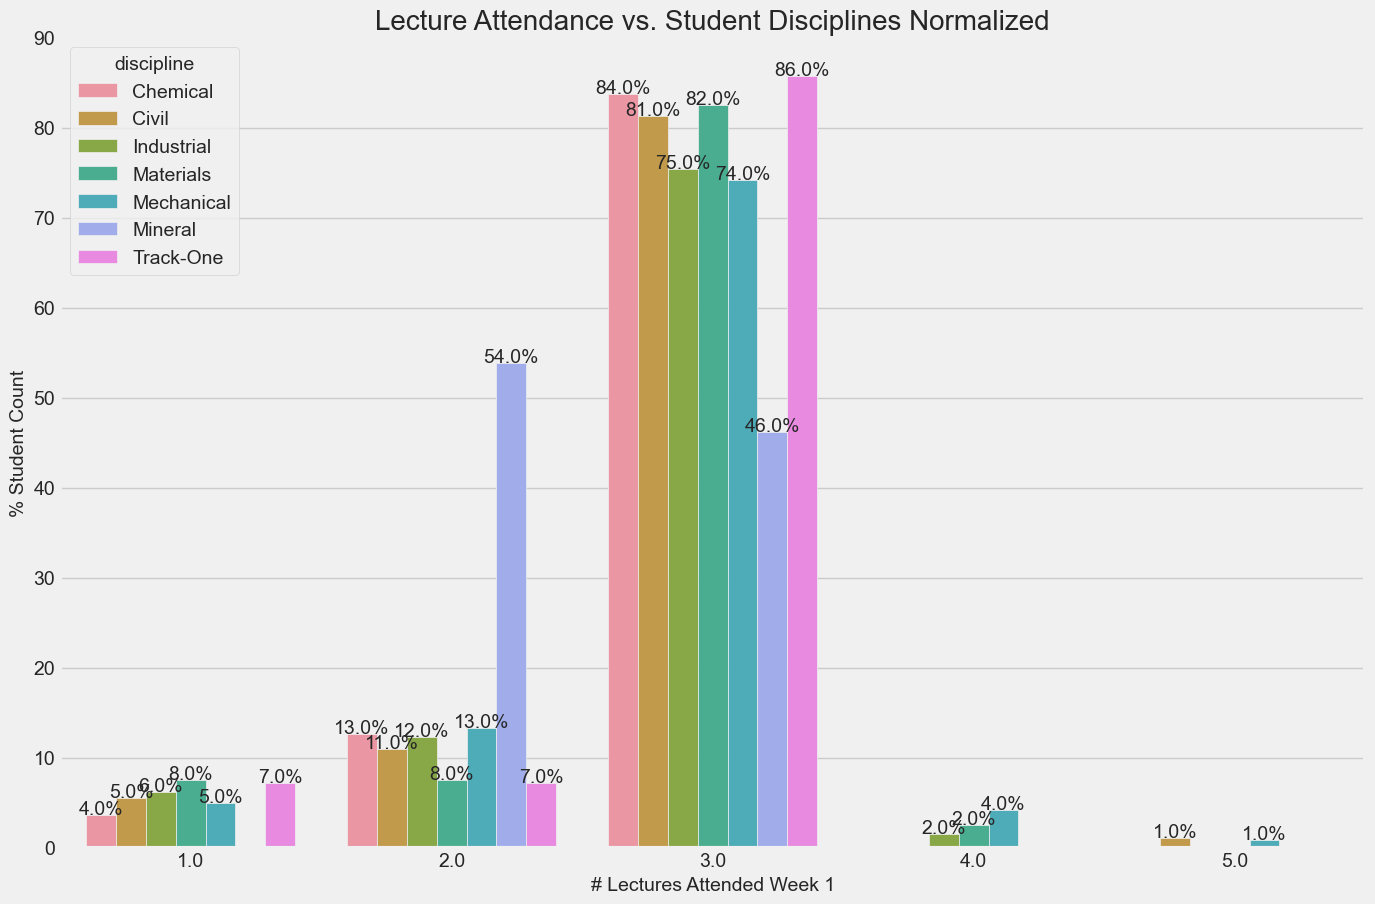

In [13]:
#define the total counts per discipline
total_students = dict(combined_df['discipline'].value_counts())

#define separate dataframe based on student discipline + attendance counts
agg_students = combined_df.groupby(['discipline','lecture_count']).count()
agg_students = agg_students.reset_index()
agg_students =  agg_students[["discipline","lecture_count","section"]].copy()
#agg_students = agg_students[agg_students['lecture_count']!=0]

agg_students['total_count'] = agg_students['discipline'].map(total_students)
agg_students['percent'] = agg_students['section'] / agg_students['total_count'] * 100  

plt.figure(figsize=(15,10)) 
plt.title('Lecture Attendance vs. Student Disciplines Normalized', fontsize = 20)
ax = sns.barplot(x="lecture_count", y="percent", hue="discipline", data=agg_students) 

# add labels
for i, p in enumerate(ax.patches):
    height = p.get_height() 
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,"{}%".format(round(height,0)),ha="center")

ax.set_ylabel('% Student Count', fontsize=14)
ax.set_xlabel('# Lectures Attended Week 1', fontsize=14)

plt.show()

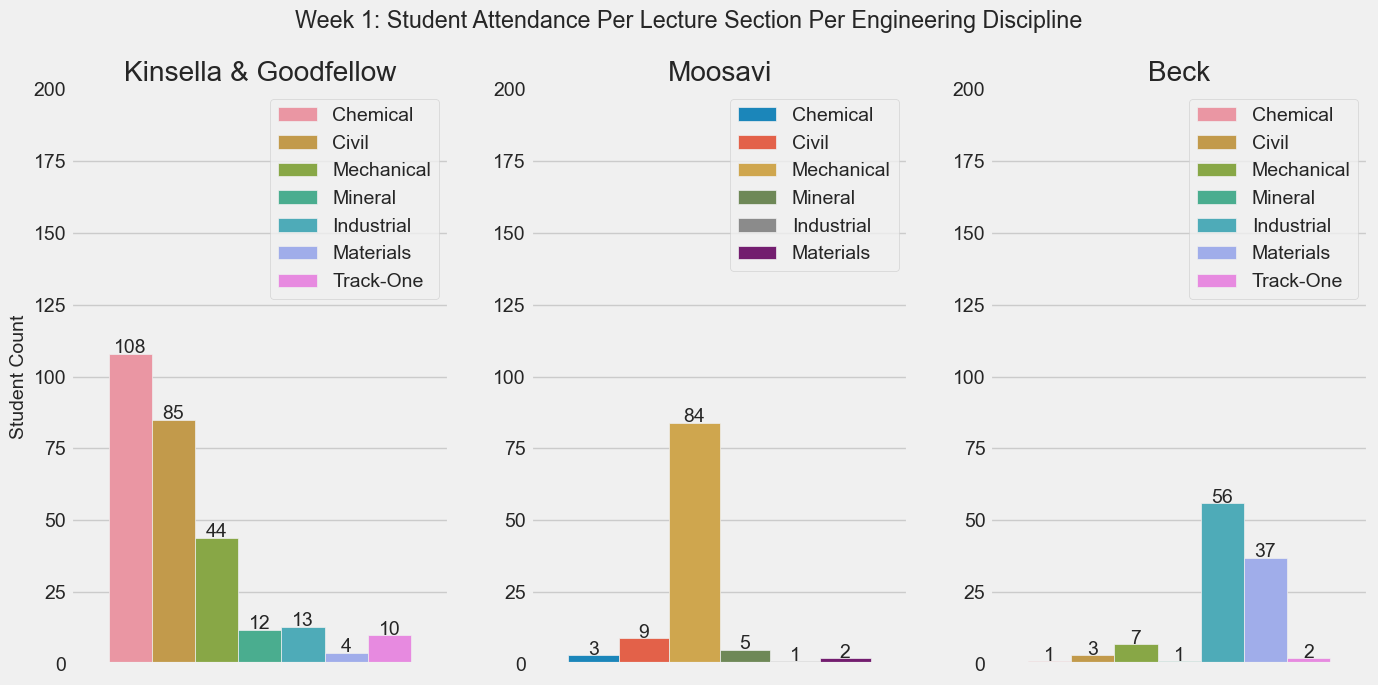

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(14, 7))

fig.suptitle("Week 1: Student Attendance Per Lecture Section Per Engineering Discipline")

column_list = ["LEC0101_attended","LEC0102_attended","LEC0103_attended"]
lecture_list = [ x.split('_')[0] for x in column_list]

# convert discipline columns to numeric (so consistent between lecture sections)
disciplines_num = {
    "Chemical":1,
    "Civil":2,
    "Mechanical":3,
    "Mineral":4,
    "Industrial":5,
    "Materials":6,
    "Track-One":7, 
    "Non-Degree":8
    }

combined_df['discipline_num'] = combined_df['discipline'].map(disciplines_num) 

for index, value in enumerate(column_list):
    sns.countplot(x=value, hue="discipline_num", data=combined_df[combined_df[value]==lecture_list[index]], ax=axs[index])
    axs[index].get_xaxis().set_visible(False)
    axs[index].set_ylim(0,200)
    axs[index].set_title(lecture_name[lecture_list[index]])
    axs[index].legend(labels = list(disciplines_num.keys()))

    for i, p in enumerate(axs[index].patches):
        height = p.get_height()
        axs[index].text(p.get_x()+p.get_width()/2., height + 0.1,"{}".format(str(p).split(',')[3].split('=')[1][0:4]),ha="center")

    if index == 0:
        axs[index].set_ylabel('Student Count', fontsize=14)
    else: 
        axs[index].set_ylabel(' ')

# Rotating x-axis labels for each subplot
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout()
plt.show()

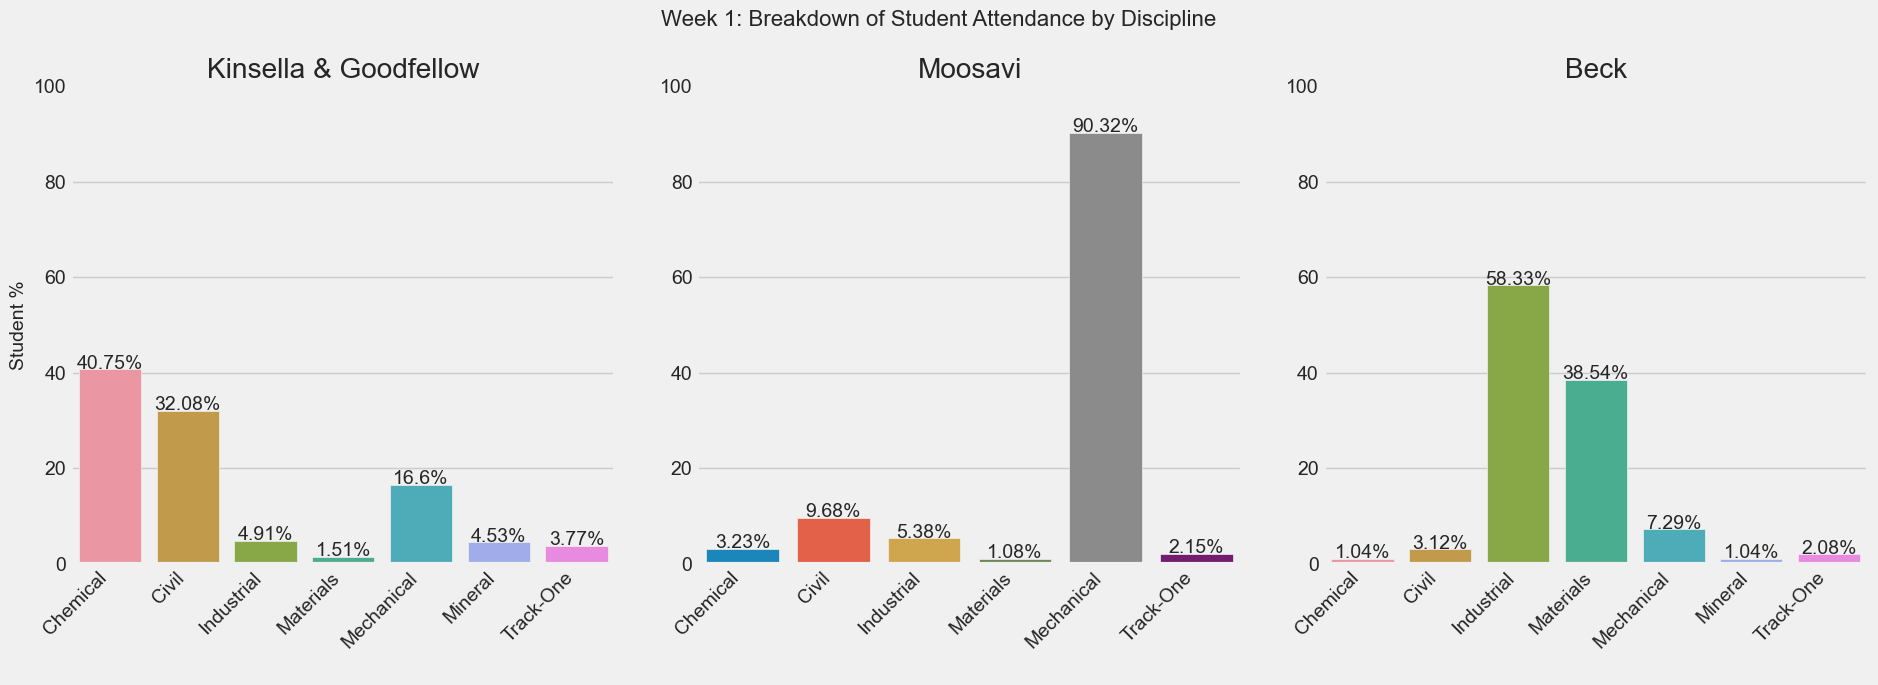

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(19, 7))

fig.suptitle("Week 1: Breakdown of Student Attendance by Discipline", size =16)

column_list = ["LEC0101_attended","LEC0102_attended","LEC0103_attended"]
lecture_list = [ x.split('_')[0] for x in column_list]

assigned_lecture = [
    len(combined_df[combined_df["Lecture"]=="LEC0101"]),
    len(combined_df[combined_df["Lecture"]=="LEC0102"]),
    len(combined_df[combined_df["Lecture"]=="LEC0103"])
]

for index, value in enumerate(column_list):

    #filter down the dataframe only to the specific lecturer
    df_temp = combined_df[combined_df[value]==lecture_list[index]]
    df_temp = df_temp.groupby("discipline").agg('count')

    df_temp =  df_temp[["section"]].copy().reset_index()
    df_temp['percent'] = df_temp['section'] / assigned_lecture[index] * 100


    sns.barplot(data=df_temp, x="discipline", y="percent", ax=axs[index])
    axs[index].set_ylim(0,100)
    axs[index].set_title(lecture_name[lecture_list[index]])

    values = list(df_temp['percent'])

    for i, p in enumerate(axs[index].patches):
        height = p.get_height()
        axs[index].text(p.get_x()+p.get_width()/2., height + 0.1,"{}%".format(round((values[i]),2)),ha="center")
    
    axs[index].set_xlabel(' ')
    if index == 0:
        axs[index].set_ylabel('Student %', fontsize=14)
    else: 
        axs[index].set_ylabel(' ')

# Rotating x-axis labels for each subplot
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout()
plt.show()

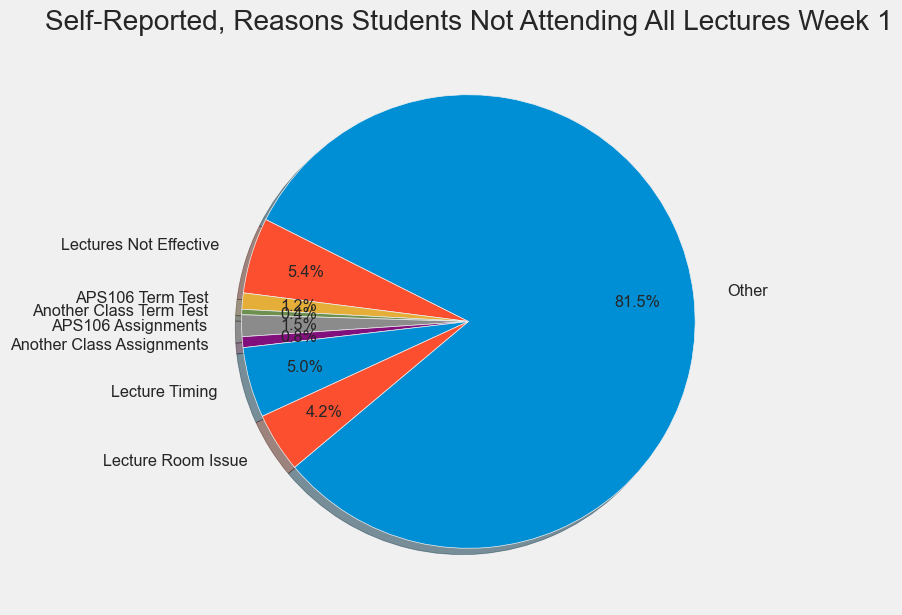

In [16]:
# reason students were not going to assigned lecture section
q2_values = {
    'Other':'Other',
    'The lectures are not an effective learning tool for me':'Lectures Not Effective',
    'I was studying for a term test for this course':'APS106 Term Test',
    'I was studying for a term test for another course':'Another Class Term Test',
    'I was working on assignments for this course':'APS106 Assignments',
    'I was working on assignments and/or projects for another course':'Another Class Assignments',
    'The lecture times make them challenging to regularly attend':'Lecture Timing',
    'The lecture room is not conducive to learning':'Lecture Room Issue'
}

q2_counts = []

for key, value in q2_values.items():
    count = combined_df['lecture_reasons'].str.contains(key)
    count = count.sum()
    q2_counts.append(count)


plt.figure(figsize=(7,7)) 
plt.title("Self-Reported, Reasons Students Not Attending All Lectures Week {}".format(week))

plt.pie(q2_counts, labels=q2_values.values(), startangle=-140,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.15)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

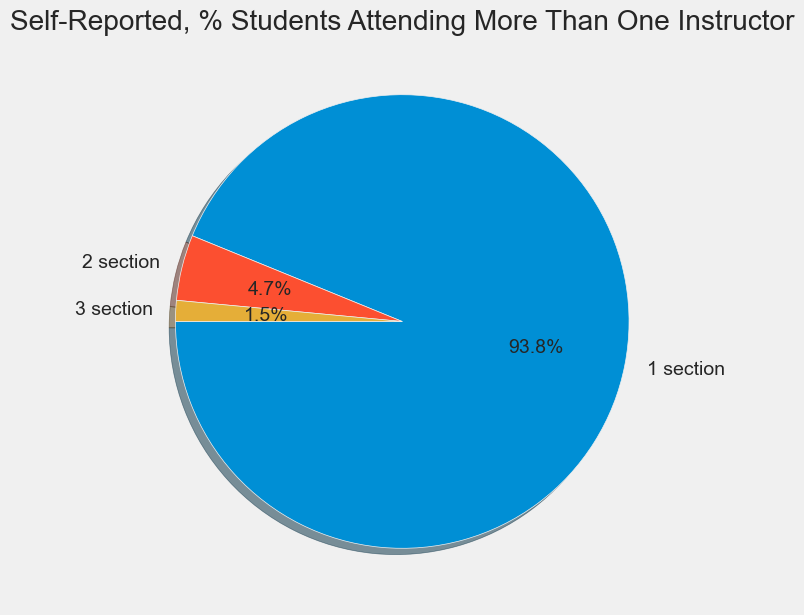

In [17]:
# how many students attended more than one instructor session last week (i.e. both Kinsella and Beck lectures)
plt.figure(figsize=(7,7)) 
plt.title("Self-Reported, % Students Attending More Than One Instructor")

# combined_df['multiple_sections'] = combined_df['lecture_sections'].str.contains(",")
combined_df['multiple_sections'] = combined_df[['LEC0101_attended', 'LEC0102_attended', 
                                                'LEC0103_attended']].applymap(lambda x: isinstance(x, str) and x != 'False').sum(axis=1)

combined_df = combined_df.sort_values(by='multiple_sections')
name = ["{} section".format(x) for x in combined_df['multiple_sections'].value_counts().keys()]
values = combined_df['multiple_sections'].value_counts()

plt.pie(values, labels=name, startangle=-180,autopct='%1.1f%%', shadow=True)
plt.show()

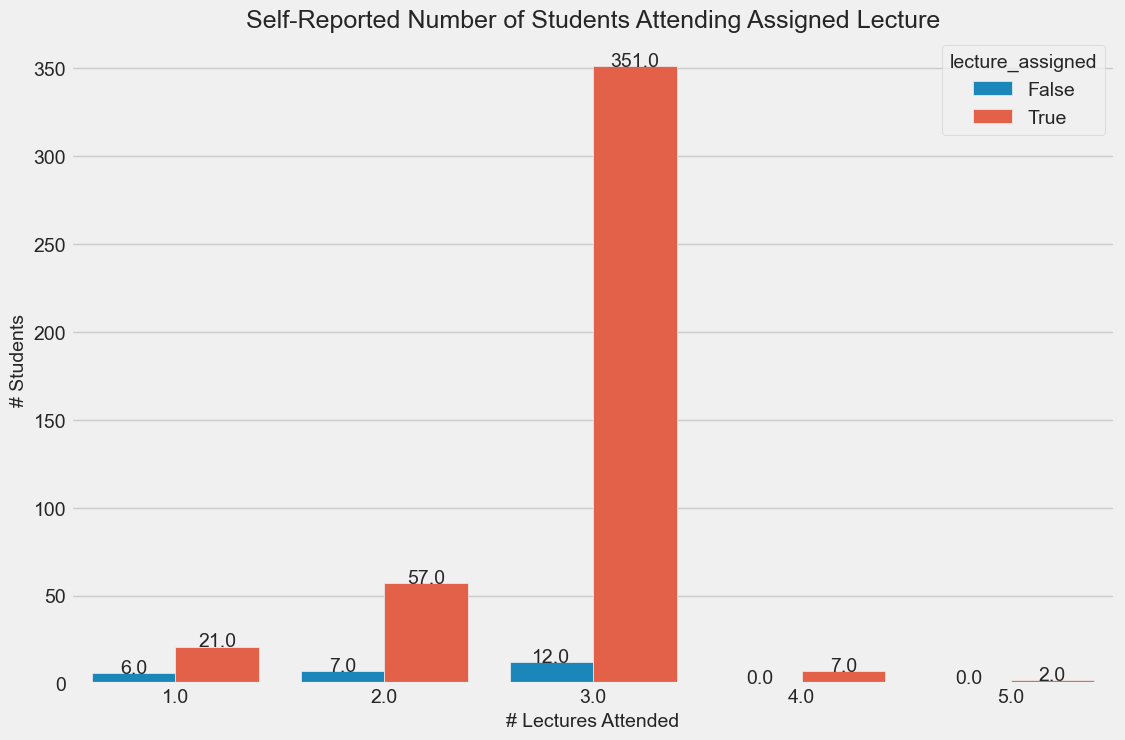

In [18]:
# how many students are not attending their assigned lecture section?
plt.figure(figsize=(12,8)) 

plt.title('Self-Reported Number of Students Attending Assigned Lecture', fontsize = 18)
ax = sns.countplot(x="lecture_count", hue="lecture_assigned", data=combined_df[combined_df['lecture_count']>0]) 

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, height ,ha="center")

ax.set_xlabel('# Lectures Attended', fontsize=14)
ax.set_ylabel('# Students', fontsize=14)

plt.show()

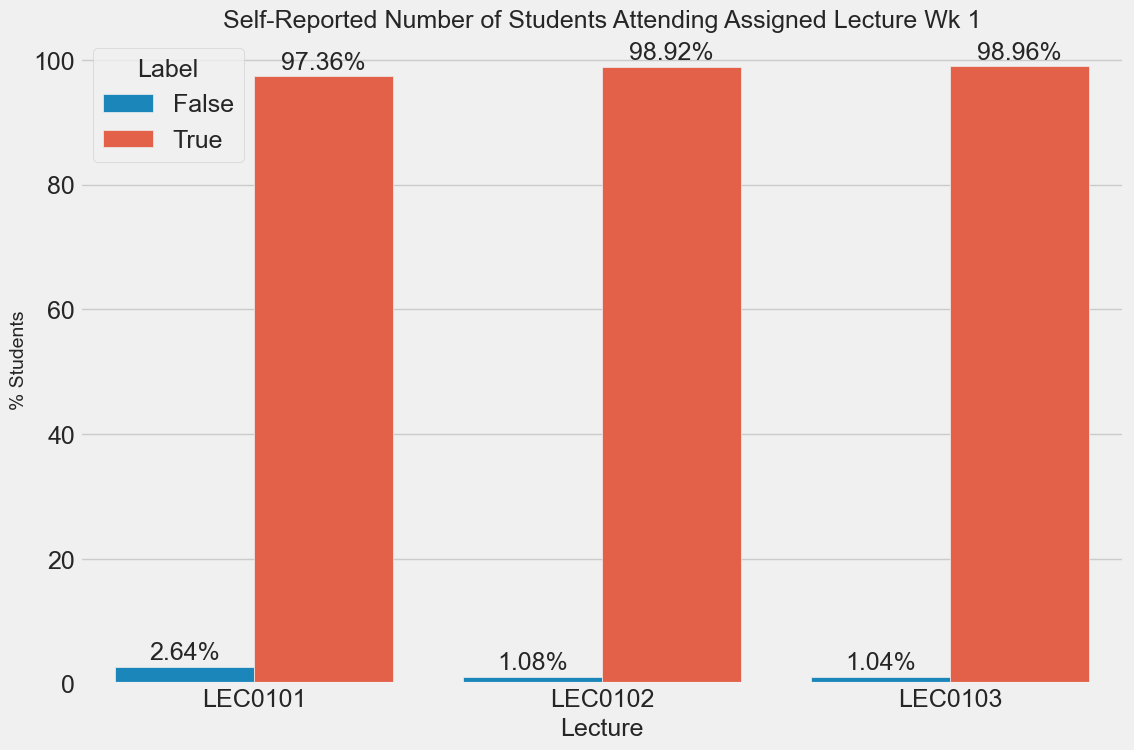

In [25]:
# how many students are not attending their assigned lecture section?
plt.figure(figsize=(12,8)) 

plt.title('Self-Reported Number of Students Attending Assigned Lecture Wk {}'.format(week), fontsize = 18)
combined_df['lecture_name_assigned'] = combined_df['Lecture'].map(lecture_name) 

lectures = []
counts = []
labels = []

# need to loop through each lecture, generate a new dataframe
for lecture in lecture_name:
    temp_df = combined_df[combined_df['Lecture']==lecture]
    total = len(temp_df)
    counts.append(len(temp_df[temp_df['lecture_assigned']==True]) / total*100)
    counts.append(len(temp_df[temp_df['lecture_assigned']==False]) / total*100)
    labels.append(True)
    labels.append(False)
    lectures.append(lecture)
    lectures.append(lecture)


lecture_df = pd.DataFrame({'Lecture':lectures,'Assigned Lecture':counts,'Label':labels})

ax = sns.barplot(x="Lecture", y = 'Assigned Lecture', hue="Label", data=lecture_df) 

# ax.set_xlabel('Total Students Present per Lecture Section', fontsize=14)
ax.set_ylabel('% Students', fontsize=14)

# Annotate each bar with its value, rounded to two decimal places
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()

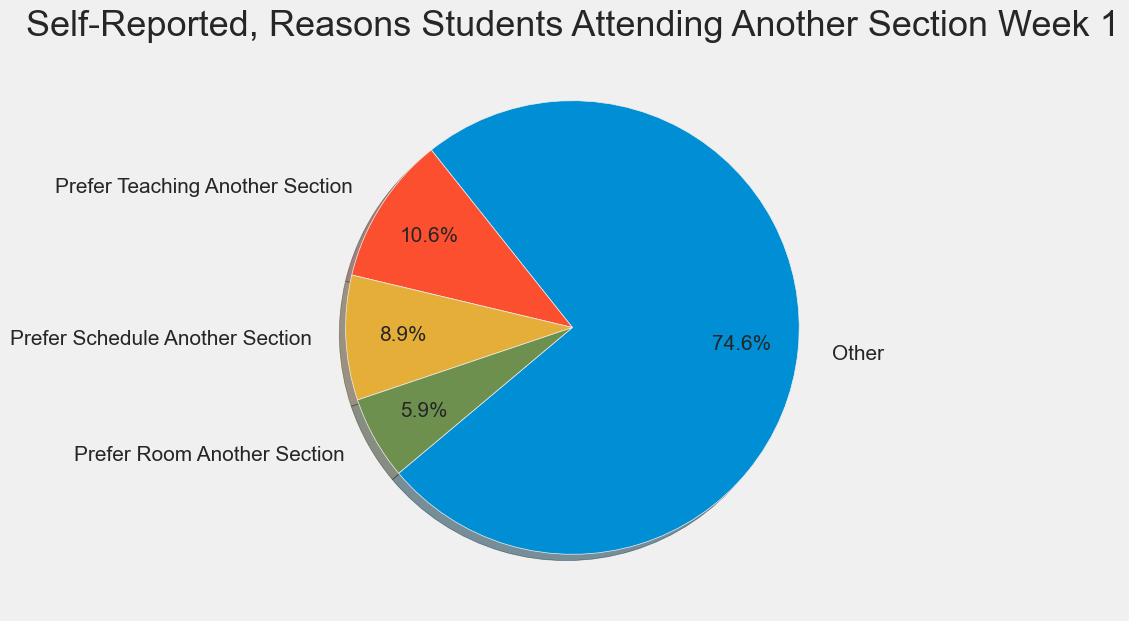

In [26]:
# reasons students not going to assigned lecture
q3_values = {
    'Other':'Other',
    'teaching style': 'Prefer Teaching Another Section',
    'scheduling': 'Prefer Schedule Another Section',
    'room': 'Prefer Room Another Section'
}

q3_counts = []

for key, value in q3_values.items():
    count = combined_df['lecture_alternate_section'].str.contains(key)
    count = count.sum()
    q3_counts.append(count)


plt.figure(figsize=(7,7)) 
plt.title("Self-Reported, Reasons Students Attending Another Section Week {}".format(week))

plt.pie(q3_counts, labels=q3_values.values(), startangle=-140,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.15)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

# Student Comfort Level with Coding

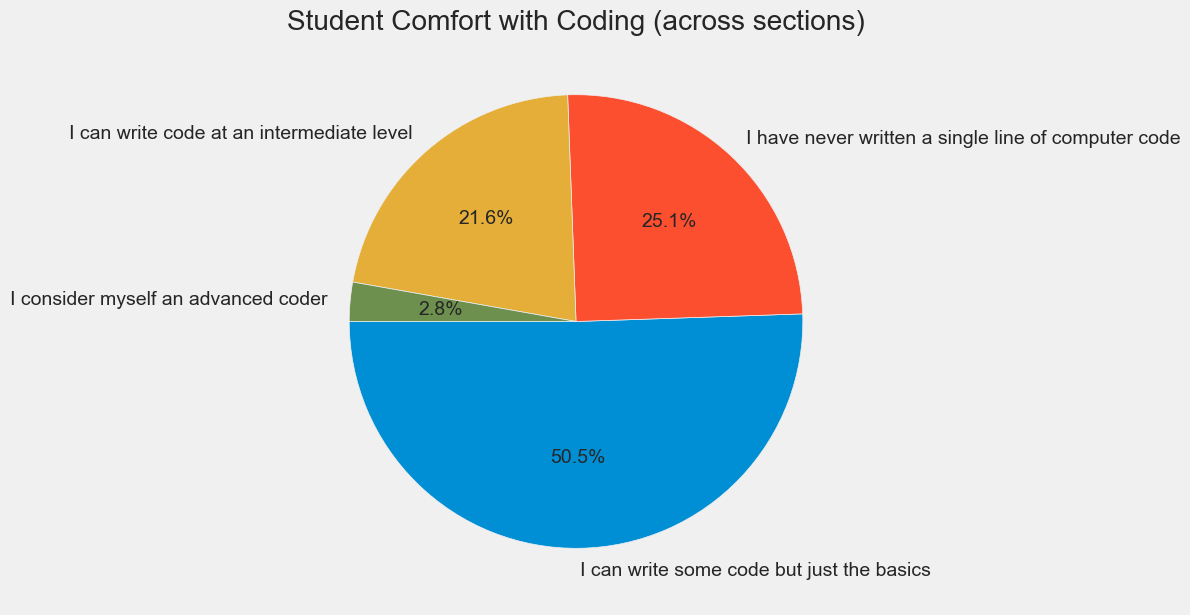

In [21]:
# how many students in each tutorial section
plt.figure(figsize=(7,7)) 
plt.title("Student Comfort with Coding (across sections)")

name = list(dict(combined_df.previous_exp.value_counts()).keys())
values = list(dict(combined_df.previous_exp.value_counts()).values())

explode = (0, 0, 0,0)

plt.pie(values, labels=name,  startangle=-180,autopct='%1.1f%%',explode=explode)
plt.show()

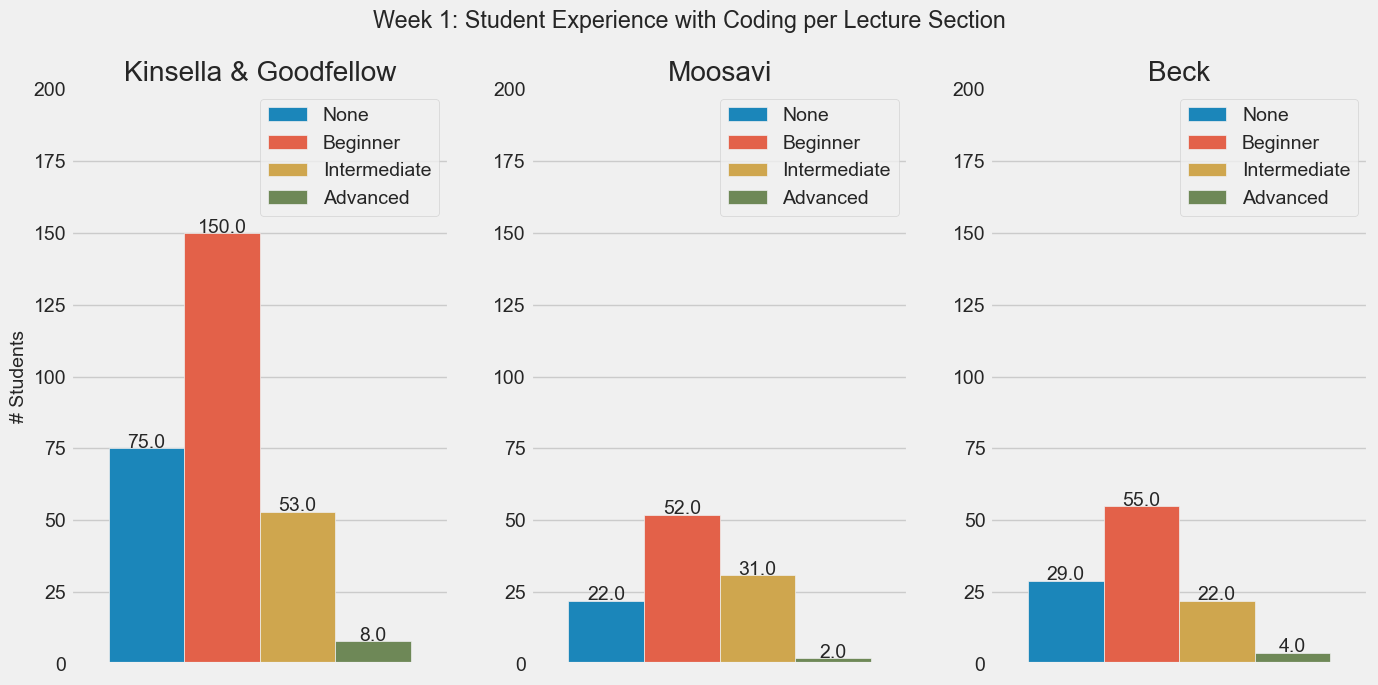

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(14, 7))

fig.suptitle("Week 1: Student Experience with Coding per Lecture Section")

column_list = ["LEC0101_attended","LEC0102_attended","LEC0103_attended"]
lecture_list = [ x.split('_')[0] for x in column_list]

# convert discipline columns to numeric (so consistent between lecture sections)
exp_num = {
    'I have never written a single line of computer code': 0,
    'I can write some code but just the basics': 1,
    'I can write code at an intermediate level': 2,
    'I consider myself an advanced coder': 3
    }       

labels = ["None", "Beginner", "Intermediate", "Advanced"]

combined_df['Experience'] = combined_df['previous_exp'].map(exp_num) 

for index, value in enumerate(column_list):
    sns.countplot(x=value, hue="Experience", data=combined_df[combined_df[value]==lecture_list[index]], ax=axs[index])
    axs[index].get_xaxis().set_visible(False)
    axs[index].set_ylim(0,200)
    axs[index].set_title(lecture_name[lecture_list[index]])
    axs[index].legend(labels=labels)

    if index == 0:
        axs[index].set_ylabel('# Students', fontsize = 14)
    else:
        axs[index].set_ylabel(' ')

    for i, p in enumerate(axs[index].patches):
        height = p.get_height()
        axs[index].text(p.get_x()+p.get_width()/2., height + 0.1, height ,ha="center")
        
fig.tight_layout()
plt.show()

In [23]:
combined_df['previous_exp'].unique()

array(['I can write some code but just the basics',
       'I can write code at an intermediate level',
       'I have never written a single line of computer code',
       'I consider myself an advanced coder', nan], dtype=object)

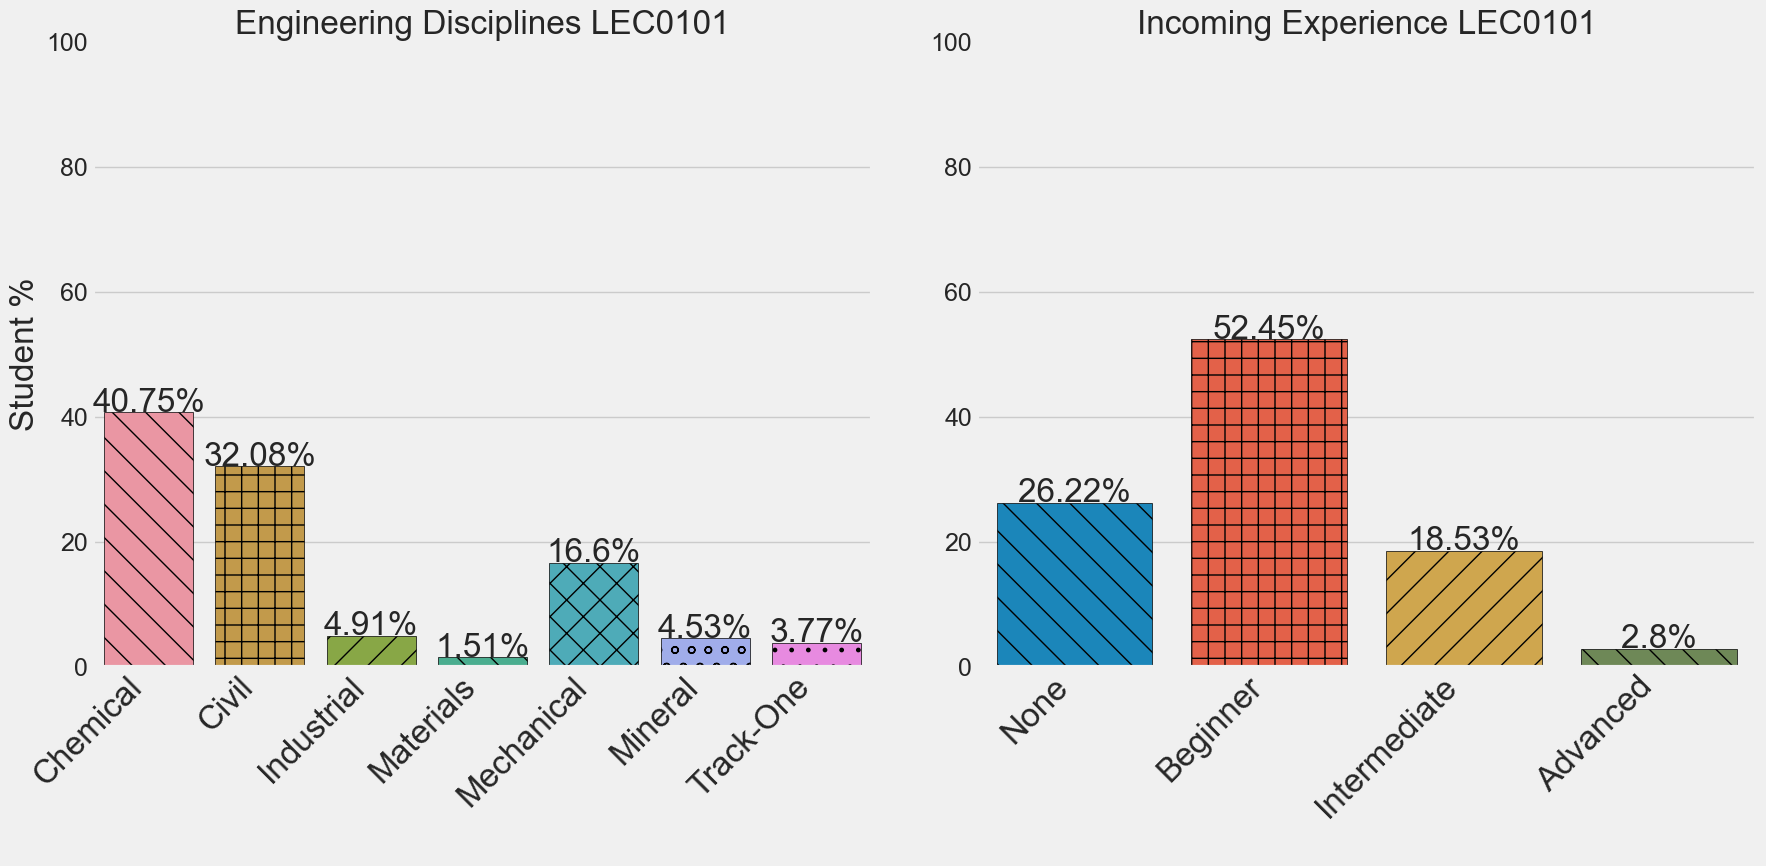

In [24]:
# Increase the global font size
matplotlib.rcParams.update({'font.size': 18})  # Adjust the value as needed

# Set up the figure and axes for the two subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

# First subplot: Breakdown of Student Attendance by Discipline for Kinsella & Goodfellow
df_temp = combined_df[combined_df["LEC0101_attended"] == "LEC0101"]
df_temp = df_temp.groupby("discipline").agg('count')
df_temp = df_temp[["section"]].copy().reset_index()
assigned_lecture = len(combined_df[combined_df["Lecture"] == "LEC0101"])
df_temp['percent'] = df_temp['section'] / assigned_lecture * 100
bar = sns.barplot(data=df_temp, x="discipline", y="percent", ax=axs[0])
    
axs[0].set_ylim(0, 100)
axs[0].set_title("Engineering Disciplines LEC0101", fontsize=24)  # Increased title font size
axs[0].set_xlabel(' ', fontsize=14)  # Increased x-axis label font size
axs[0].set_ylabel('Student %', fontsize=24)  # Increased y-axis label font size
for i, p in enumerate(axs[0].patches):
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2., height + 0.1, "{}%".format(round(df_temp['percent'].iloc[i], 2)), ha="center", fontsize=24)  # Increased annotation font size
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right', fontsize=24)  # Increased x-axis tick label font size

# Define some hatches
hatches = [ '\\','+', '/', '\\', 'x', 'o','.']

# Loop over the bars
for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')
    
# Second subplot: Adjusted to display percentages for Student Experience with Coding
experience_mapping = {
    'I can write some code but just the basics': "Beginner",
       'I can write code at an intermediate level': "Intermediate",
       'I have never written a single line of computer code': "None",
       'I consider myself an advanced coder': "Advanced"
}

combined_df['Experience_Category'] = combined_df['previous_exp'].map(experience_mapping)

experience_percent = combined_df[combined_df["LEC0101_attended"] == "LEC0101"]['Experience_Category'].value_counts(normalize=True) * 100
experience_percent_df = experience_percent.reset_index()
experience_percent_df.columns = ['Experience_Category', 'percent']

bar2 = sns.barplot(data=experience_percent_df, x='Experience_Category', y='percent', ax=axs[1], order=["None", "Beginner", "Intermediate", "Advanced"])
    
axs[1].set_ylim(0, 100)
axs[1].set_title("Incoming Experience LEC0101", fontsize=24)  # Increased title font size
axs[1].set_xlabel(' ', fontsize=20)  # Increased x-axis label font size
axs[1].set_ylabel(' ', fontsize=20)  # Increased y-axis label font size (even though it's empty)
for i, p in enumerate(axs[1].patches):
    height = p.get_height()
    axs[1].text(p.get_x() + p.get_width() / 2., height + 0.1, "{}%".format(round(height, 2)), ha="center", fontsize=24)  # Increased annotation font size
axs[1].set_xticklabels(["None", "Beginner", "Intermediate", "Advanced"], rotation=45, ha='right', fontsize=24)  # Increased x-axis tick label font size

# Define some hatches
hatches = [ '\\','+', '/', '\\']

# Loop over the bars
for i,thisbar in enumerate(bar2.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    thisbar.set_edgecolor('black')
    
fig.tight_layout()
plt.show()

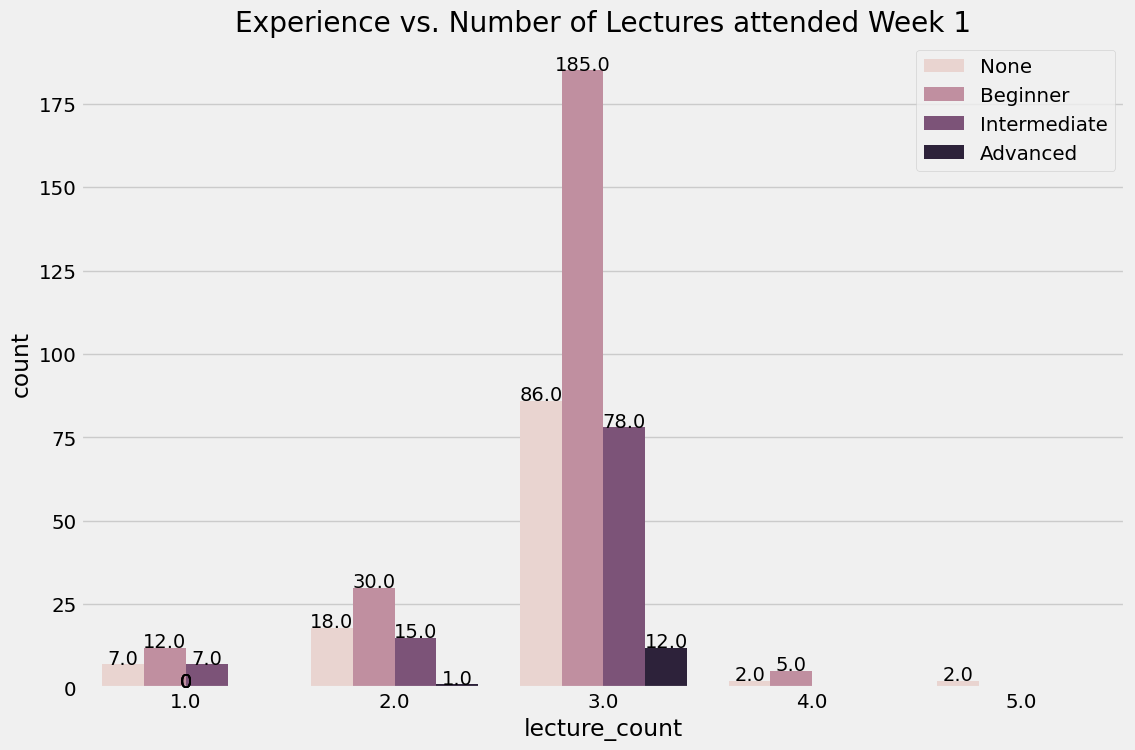

In [190]:
# comfort level correlated with attendance level
plt.figure(figsize=(12,8)) 
ax = sns.countplot(x="lecture_count", hue="Experience", data=combined_df[combined_df["lecture_count"]>0])

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, height ,ha="center")
    
plt.legend(labels=labels)
plt.title('Experience vs. Number of Lectures attended Week 1')
plt.show()

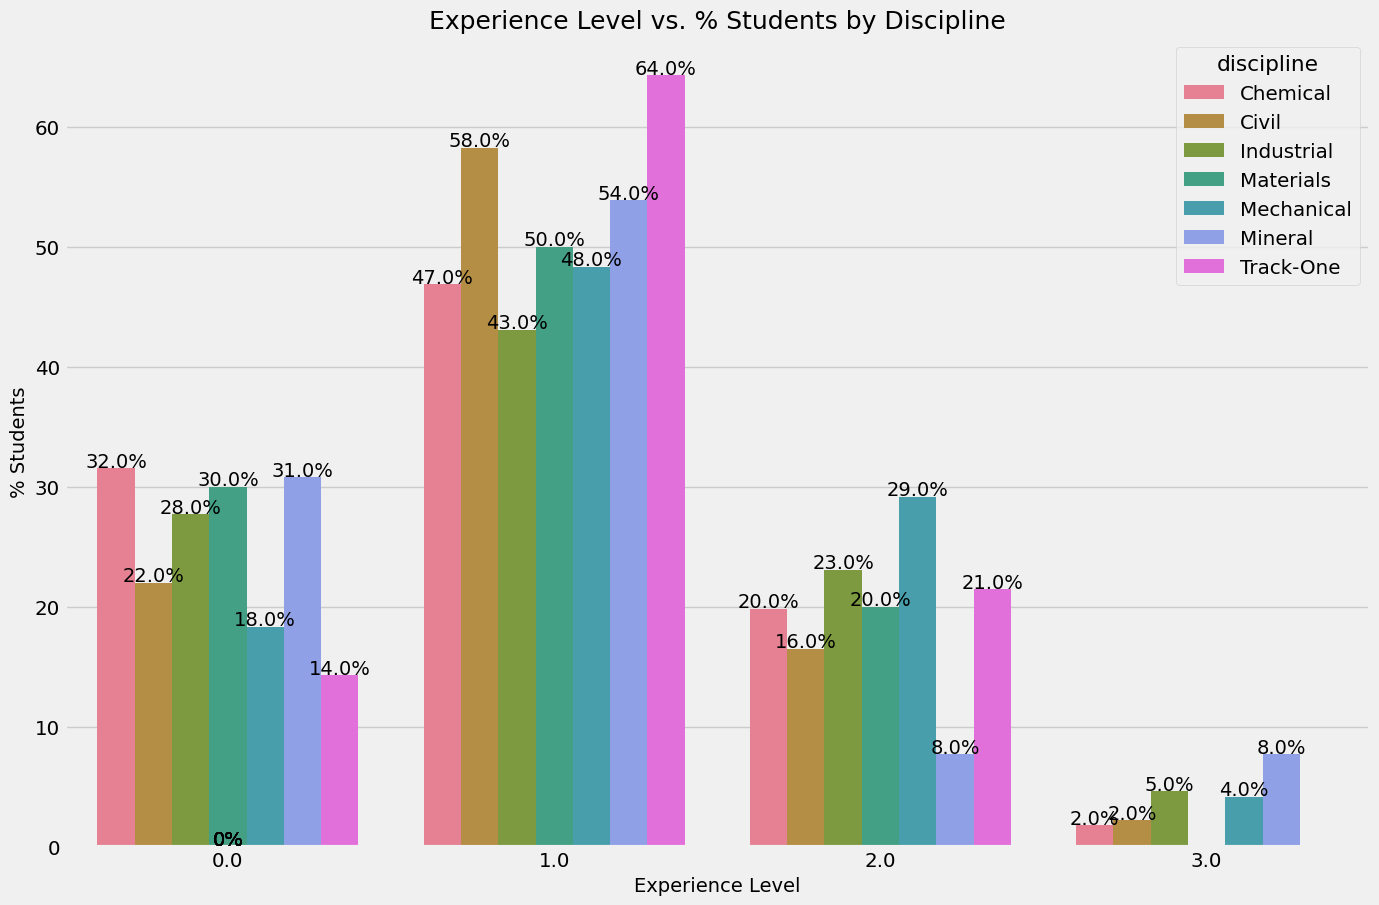

In [191]:
# show student experience vs disciple
total_students = dict(combined_df['discipline'].value_counts())

#define separate dataframe based on student discipline + attendance counts
agg_students = combined_df.groupby(['discipline','Experience']).count()
agg_students = agg_students.reset_index()
agg_students =  agg_students[["discipline","Experience","section"]].copy()

agg_students['total_count'] = agg_students['discipline'].map(total_students)
agg_students['percent'] = agg_students['section'] / agg_students['total_count'] * 100  

plt.figure(figsize=(15,10)) 
plt.title('Experience Level vs. % Students by Discipline', fontsize = 18)

agg_students.sort_values(by=['Experience'], key=lambda x: x.map(total_students),ascending=False)

ax = sns.barplot(x="Experience", y="percent", hue="discipline", data=agg_students) 

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, "{}%".format(round(height,0)) ,ha="center")

ax.set_ylabel('% Students', fontsize=14)
ax.set_xlabel('Experience Level', fontsize=14)

plt.show()

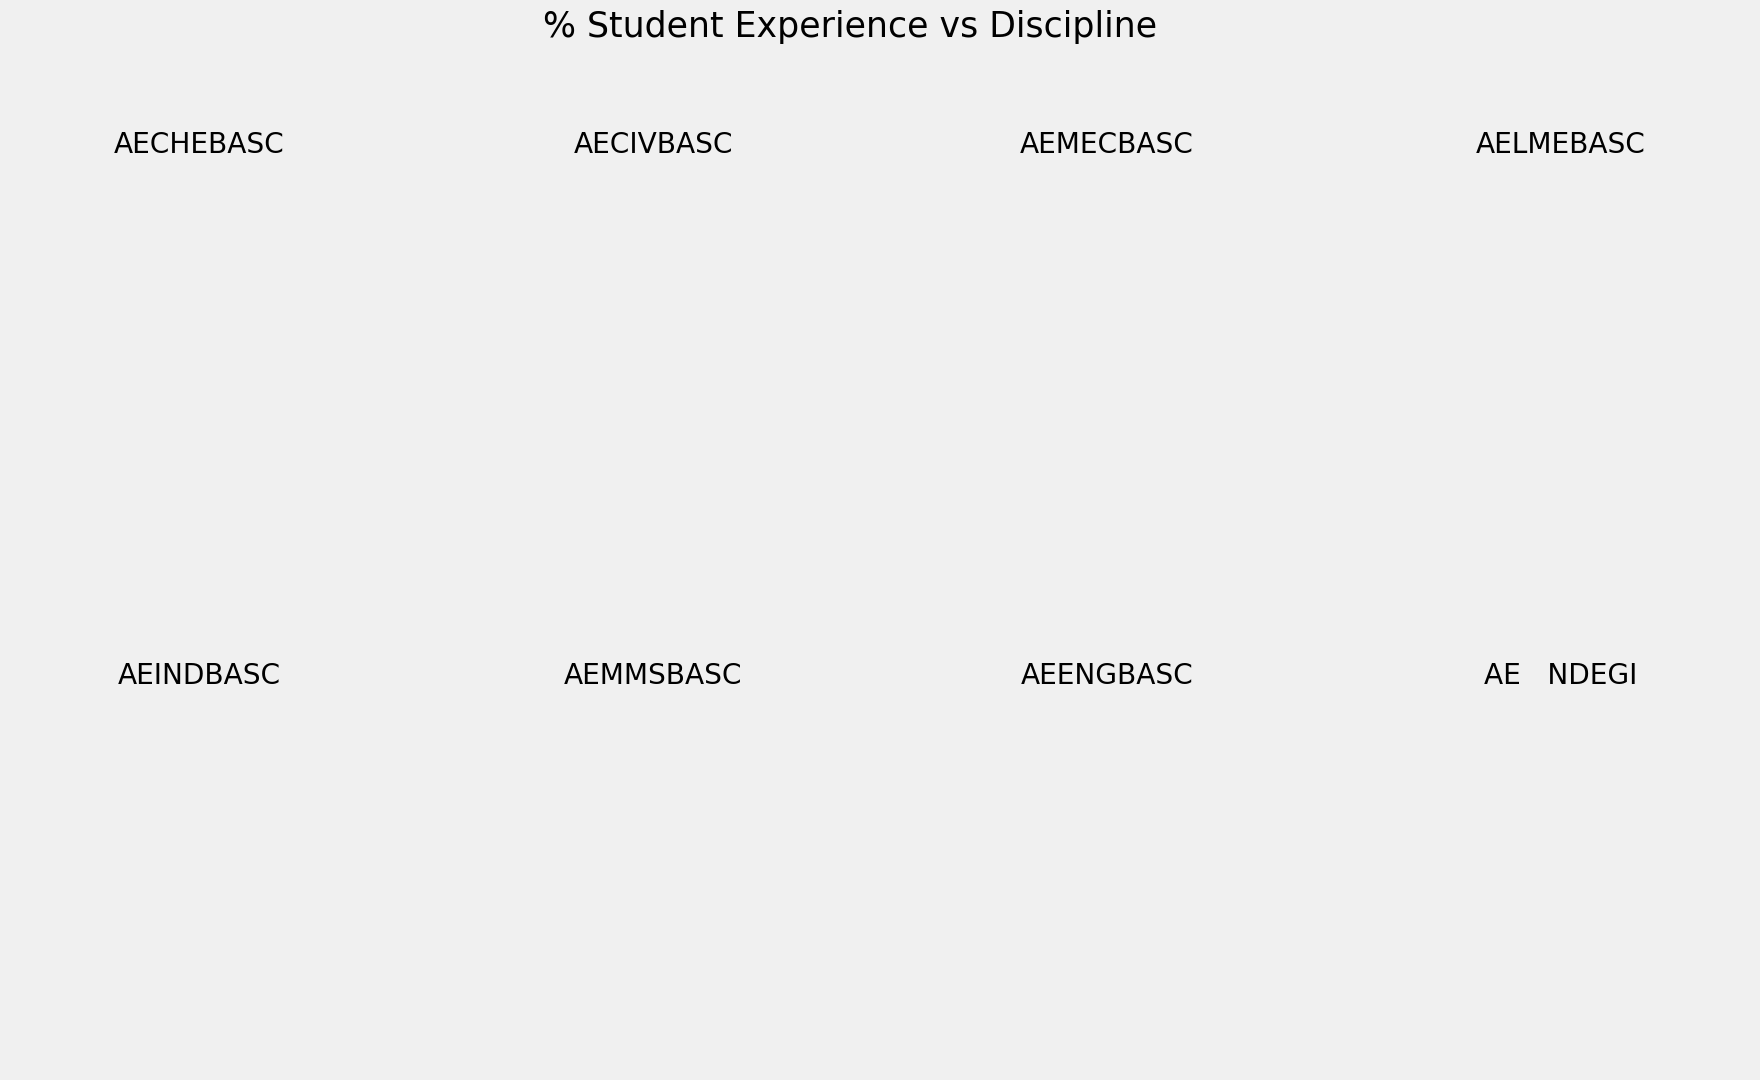

In [192]:
# looking at experience levels of students per discipline (self-identified in week 1 reflection)

# loop through disciplines, generate pie chart of experience across students

titles = [discipline for discipline in disciplines]
fig, axs = plt.subplots(2, 4, figsize=(20, 12))

fig.suptitle("% Student Experience vs Discipline", fontsize = 25)

row = 0
col = 0

sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 3})

exp_num = {
    "None": 0,
    "Beginner": 1,
    "Intermediate": 2,
    "Advanced": 3
    }

exp_label = {
    'I have never written a single line of computer code': 'None',
    'I can write some code but just the basics': 'Beginner',
    'I can write code at an intermediate level': 'Intermediate',
    'I consider myself an advanced coder': 'Advanced'
    }

combined_df['Experience_Label'] = combined_df['previous_exp'].map(exp_label) 

for index, discipline in enumerate(disciplines): 
    
    # filter the dataframe
    df_filt = combined_df[combined_df['discipline']==discipline]

    df_grouped = df_filt.groupby('Experience_Label').agg('count')
    df_grouped = df_grouped.reset_index()
    df_grouped['exp_num'] = df_grouped['Experience_Label'].map(exp_num)
    df_grouped = df_grouped.sort_values(by=['exp_num'])

    values = df_grouped['section'].to_list()
    labels = df_grouped['Experience_Label'].to_list()
    
    axs[row,col].pie(values, labels=labels, autopct='%1.1f%%', startangle=215,)
    axs[row,col].title.set_text("{}".format(titles[index]))

    if (index + 1) % 4 == 0:
        row += 1
        col = 0 
    else:
        col += 1

plt.show()

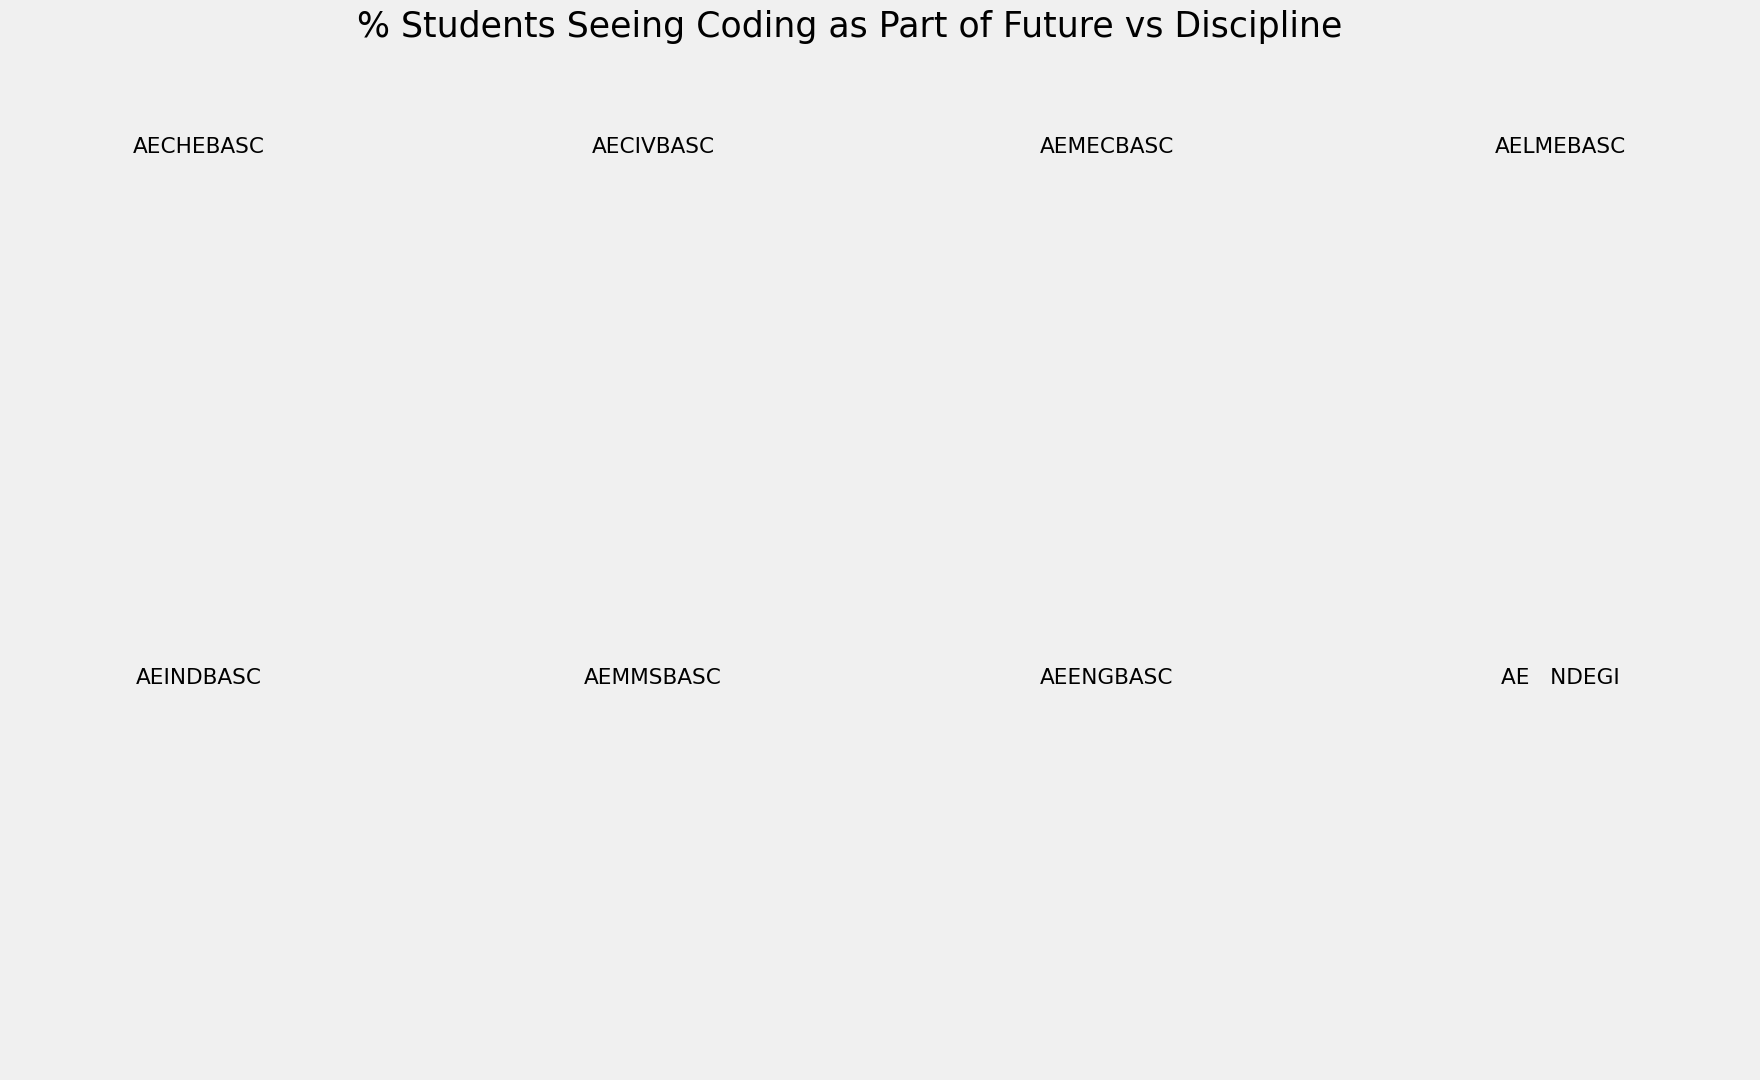

In [193]:
# looking at students per discipline, how many see coding as part of their future

# loop through disciplines, generate pie chart of experience across students

titles = [discipline for discipline in disciplines]
fig, axs = plt.subplots(2, 4, figsize=(20, 12))

fig.suptitle("% Students Seeing Coding as Part of Future vs Discipline", fontsize = 25)

row = 0
col = 0

sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 3})

combined_df['coding_future'] = combined_df['coding_future'].fillna('Not sure')
combined_df['coding_future'] = combined_df['coding_future'].replace(0, 'Not sure')

for index, discipline in enumerate(disciplines): 
    
    # filter the dataframe
    df_filt = combined_df[combined_df['discipline']==discipline]

    values = dict(df_filt['coding_future'].value_counts()).values()
    labels = dict(df_filt['coding_future'].value_counts()).keys()
    
    axs[row,col].pie(values, labels=labels, autopct='%1.1f%%', startangle=215,)
    axs[row,col].title.set_text("{}".format(titles[index]))

    if (index + 1) % 4 == 0:
        row += 1
        col = 0 
    else:
        col += 1

plt.show()

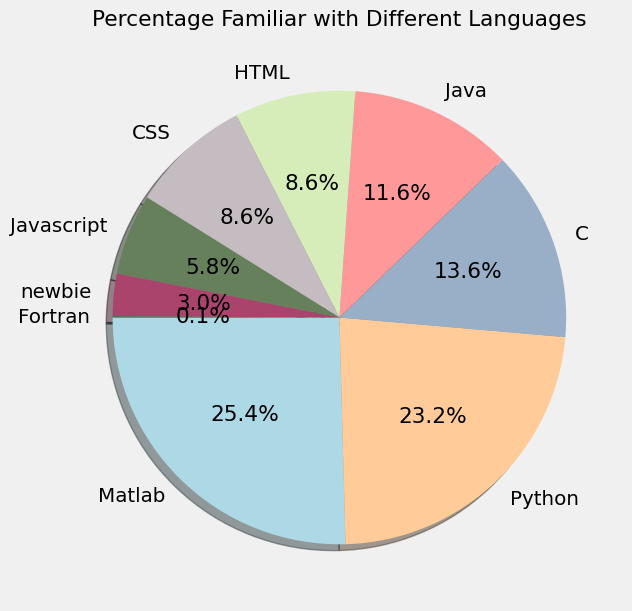

In [194]:
# how many students attended more than one instructor session last week (i.e. both Kinsella and Rosu lectures)
plt.figure(figsize=(7,7)) 
plt.title("Percentage Familiar with Different Languages")

name = list(dict(languages.words_).keys())
values = list(dict(languages.words_).values())

plt.pie(values, labels=name, colors=colors, startangle=-180,autopct='%1.1f%%', shadow=True)
plt.show()

# Individual Topics Covered During the Week

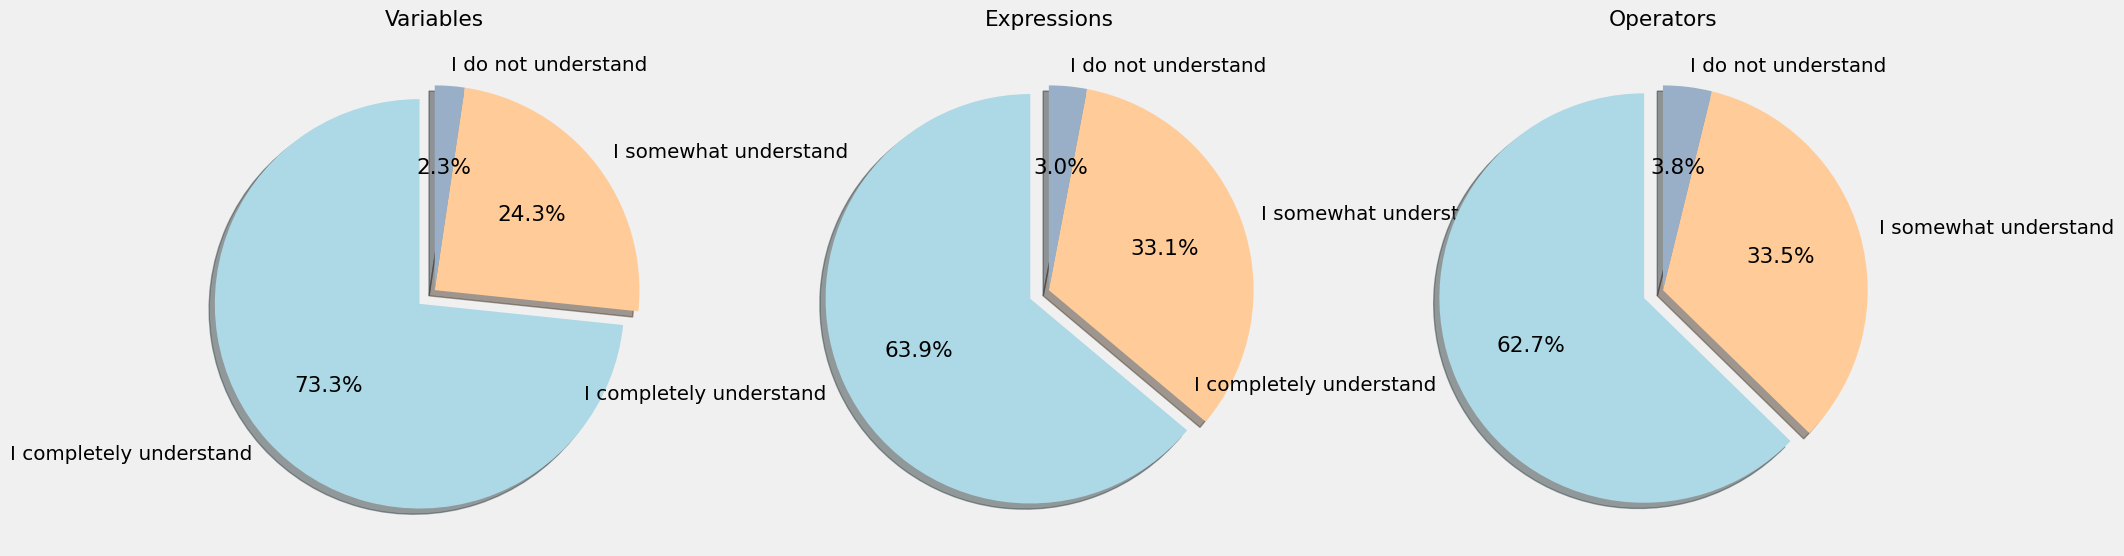

In [195]:
# check general % of students comfortable with the new topics

columns = ['variable_check', 'expression_check', 'operator_check']
fig, ax = plt.subplots(1,len(columns), figsize=(20, 20))


for index, value in enumerate(columns): 
    column = dict(combined_df[value].value_counts())
    data = list(column.values())
    labels = list(column.keys())

    explode = (0.1, 0, 0)
    
    total = sum(data)
    data_per = data/total*100
    
    ax[index].pie(data_per, labels = labels, colors = colors, autopct='%1.1f%%', shadow=True, startangle=90,explode=explode)
    ax[index].title.set_text("{}s".format(str(columns[index]).split("_")[0].capitalize()))


plt.show()

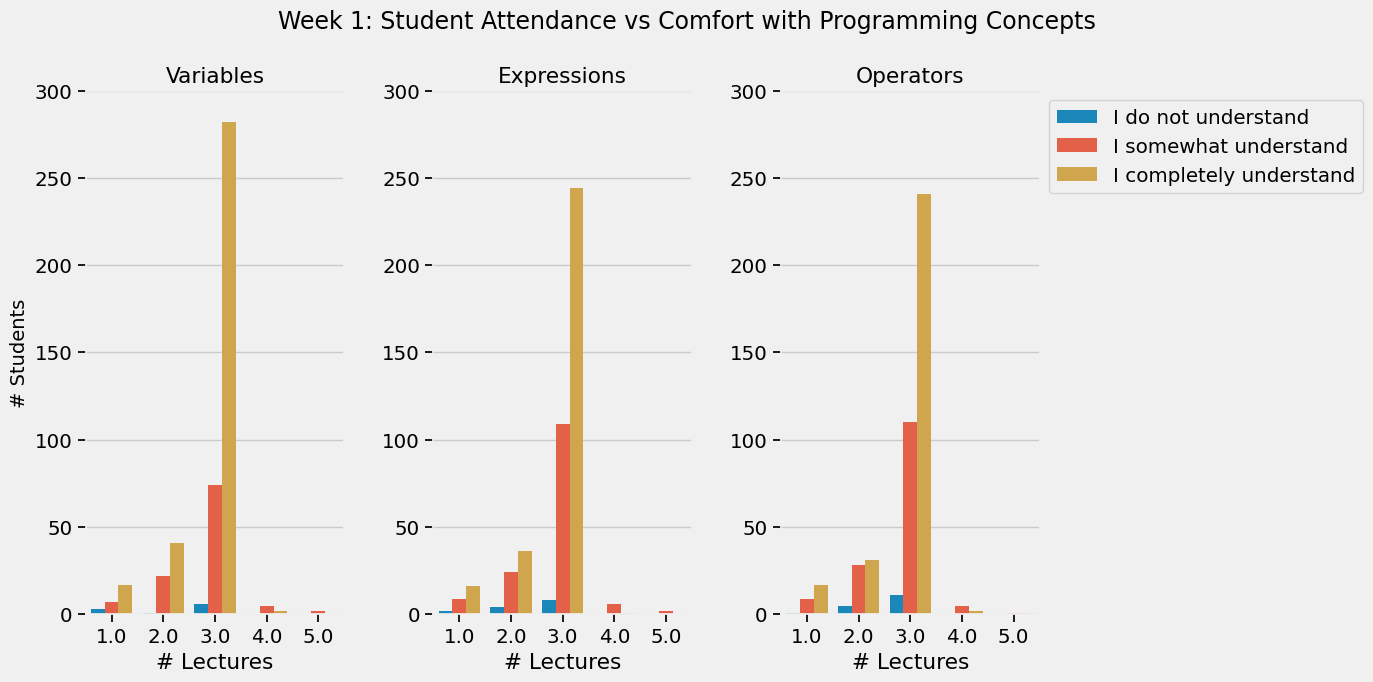

In [196]:
# comfort level correlated with attendance level

fig, axs = plt.subplots(1, 3, figsize=(14, 7))

fig.suptitle("Week 1: Student Attendance vs Comfort with Programming Concepts", fontsize = 17)
columns = ['variable_check', 'expression_check', 'operator_check']

numeric = {
    'I do not understand': 0,
    'I somewhat understand': 1,
    'I completely understand': 2
}

new_column = [ x + '_numeric' for x in columns]

for index, value in enumerate(columns):

    combined_df[new_column[index]] = combined_df[value].map(numeric)

    sorted_df = combined_df.sort_values(by=[new_column[index]])
    sns.countplot(x="lecture_count", hue=value, data=sorted_df, ax=axs[index])
    axs[index].set_title("{}s".format(str(value.split("_")[0].capitalize())))

    if index == 0:
        axs[index].set_ylabel("# Students", fontsize = 14)
    else:
        axs[index].set_ylabel(" ", fontsize = 6)

    axs[index].set_ylim(0,300)
    axs[index].set_xlabel('# Lectures')
    

# Remove legend from the first two plots and add it to the last plot
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1))
    
fig.tight_layout()
plt.show()

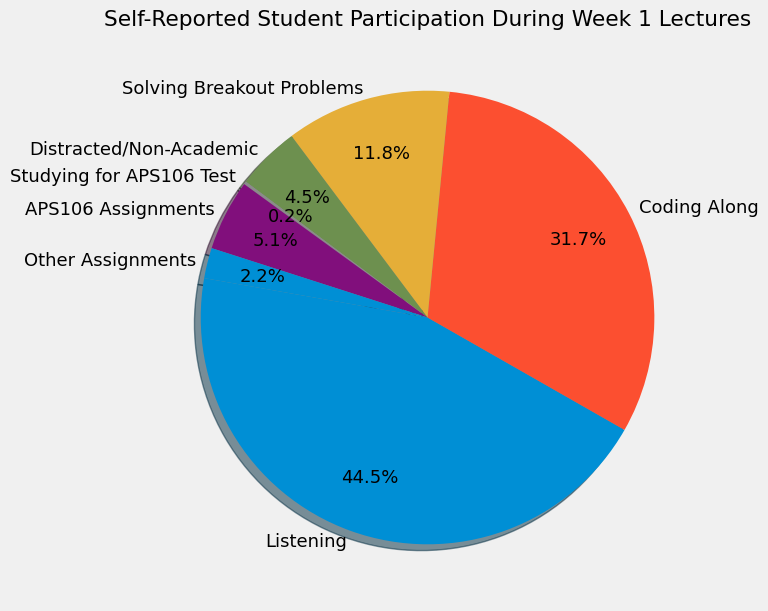

In [197]:
# what did students do in lecture during the week

q4_values = [
    'Following the lecture by looking at the content and listening to the instructor',
    'Coding along with the instructor on my device',
    'Trying to solve the breakout problems',
    'Distracted with non-academic activities',
    'I was studying for a term test for this course',
    'I was studying for a term test for another course',
    'I was working on assignments for this course',
    'I was working on assignments and/or projects for another course'
]

q4_labels = [
    'Listening',
    'Coding Along',
    'Solving Breakout Problems',
    'Distracted/Non-Academic',
    'Studying for APS106 Test',
    'Studying for Other Test',
    'APS106 Assignments',
    'Other Assignments'
]

q4_counts = []

for value in q4_values:
    count = combined_df['hybrid_learning'].str.contains(value)
    count = count.sum()
    q4_counts.append(count)

for index, value in enumerate(q4_counts):
    if value == 0:
        q4_counts.remove(0)
        q4_values.pop(index)
        q4_labels.pop(index)

plt.figure(figsize=(7,7)) 
plt.title("Self-Reported Student Participation During Week {} Lectures".format(week))

plt.pie(q4_counts, labels=q4_labels, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.05)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

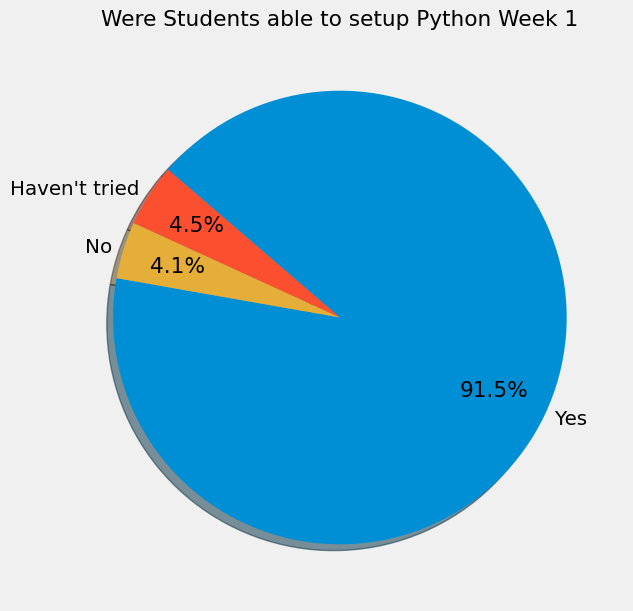

In [198]:
# were students able to setup Python in week 1?

# are students feeling up to date or behind

plt.figure(figsize=(7,7)) 
plt.title("Were Students able to setup Python Week {}".format(week))

values = dict(combined_df['python_setup'].value_counts()).values()
labels = dict(combined_df['python_setup'].value_counts()).keys()

plt.pie(values, labels=labels, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.05)

plt.show()

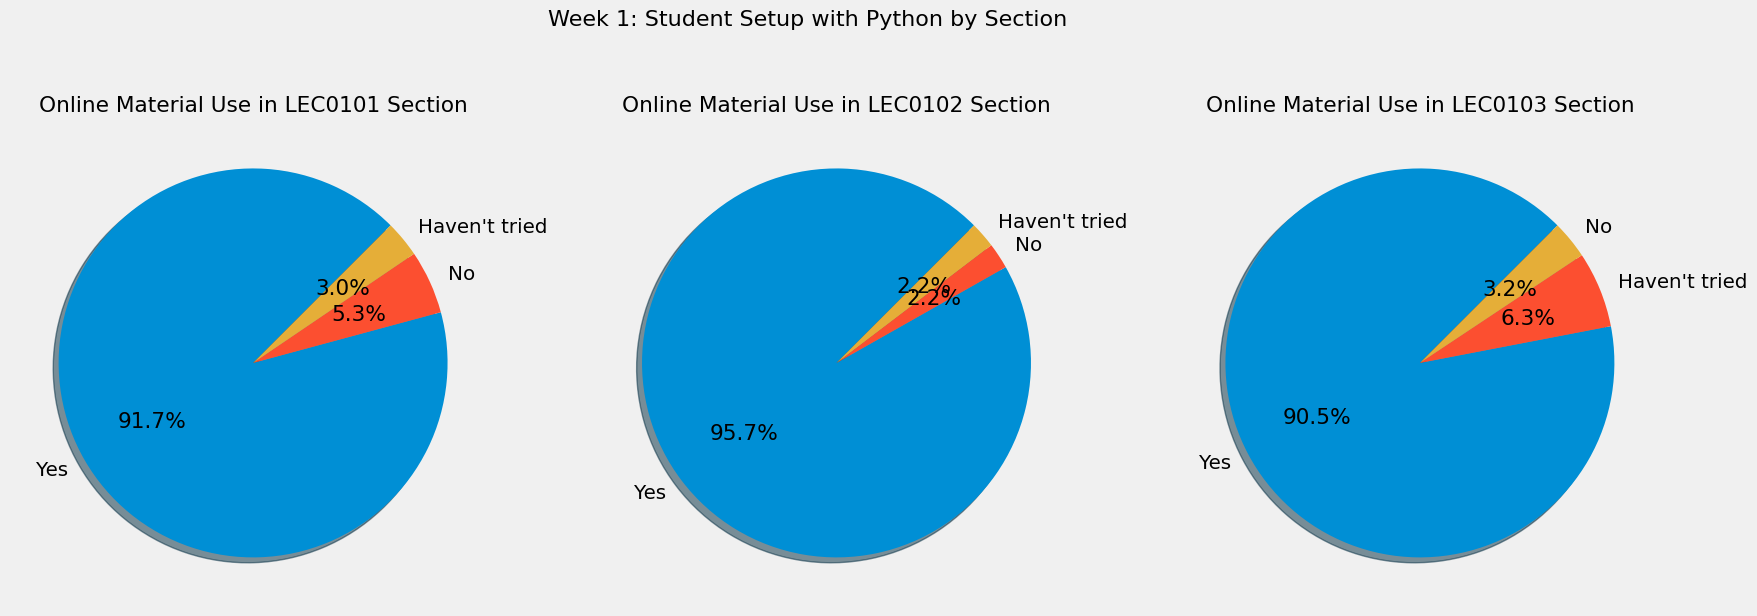

In [199]:
# which video materials are people using per lecture section

fig, axs = plt.subplots(1, 3, figsize=(19, 7))

fig.suptitle("Week {}: Student Setup with Python by Section".format(week), size =16)

for index, lecture in enumerate(section): # we will check against assigned lecture sections

    temp_df = combined_df[combined_df['Lecture']==lecture]

    values = dict(temp_df['python_setup'].value_counts()).values()
    labels = dict(temp_df['python_setup'].value_counts()).keys()

    axs[index].pie(values, labels = labels, autopct='%1.1f%%', shadow=True, startangle=45)
    axs[index].title.set_text("Online Material Use in {} Section".format(str(lecture_list[index])))
  
plt.show()

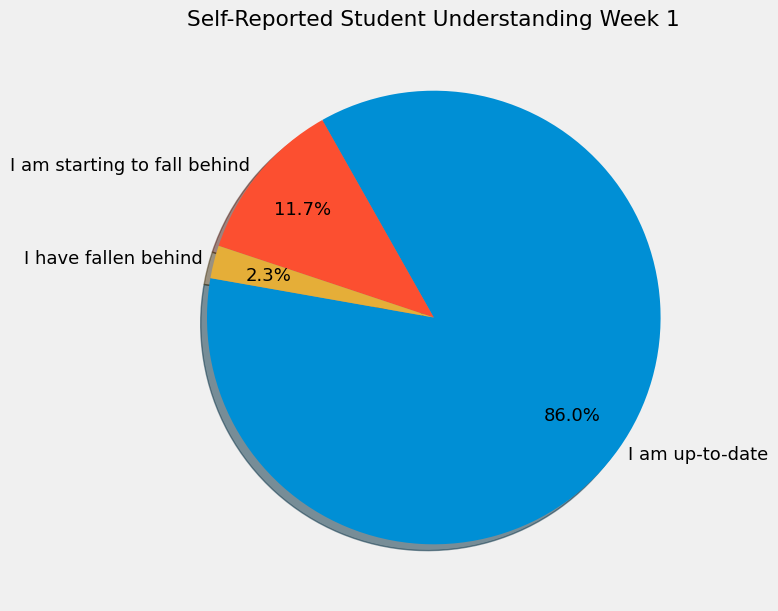

In [200]:
# are students feeling up to date or behind

plt.figure(figsize=(7,7)) 
plt.title("Self-Reported Student Understanding Week {}".format(week))

values = dict(combined_df['progress_check'].value_counts()).values()
labels = dict(combined_df['progress_check'].value_counts()).keys()

plt.pie(values, labels=labels, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.05)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

# Hybrid Materials Use

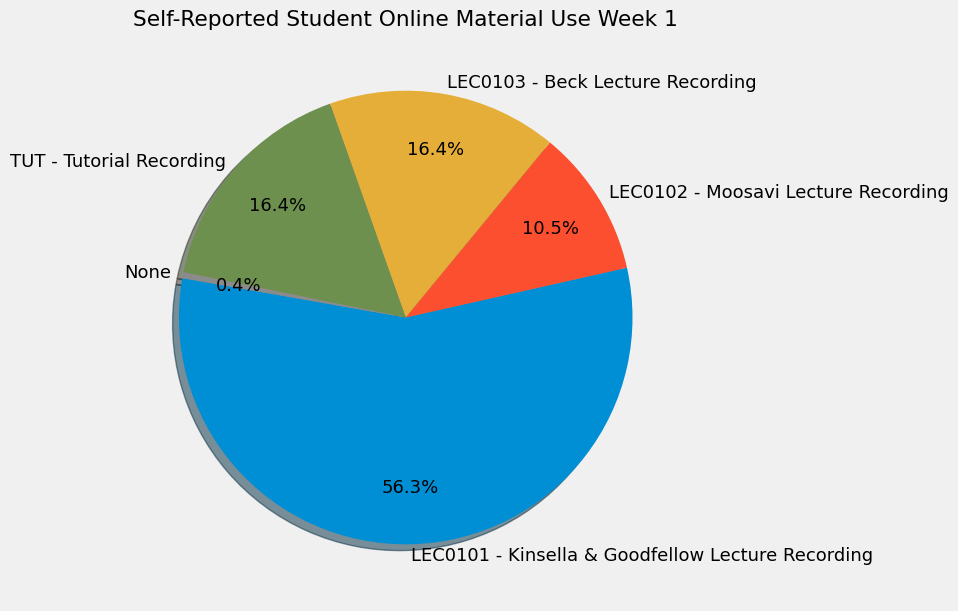

In [201]:
# which video materials are people using?
online_values = [
    'LEC0101 - Kinsella & Goodfellow Lecture Recording',
    'LEC0102 - Moosavi Lecture Recording',
    'LEC0103 - Beck Lecture Recording',
    'TUT - Tutorial Recording',
    'None'
]

online_count = []

for value in online_values:
    count = combined_df['video_materials'].str.contains(value)
    count = count.sum()
    online_count.append(count)

plt.figure(figsize=(7,7)) 
plt.title("Self-Reported Student Online Material Use Week {}".format(week))

plt.pie(online_count, labels=online_values, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.05)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

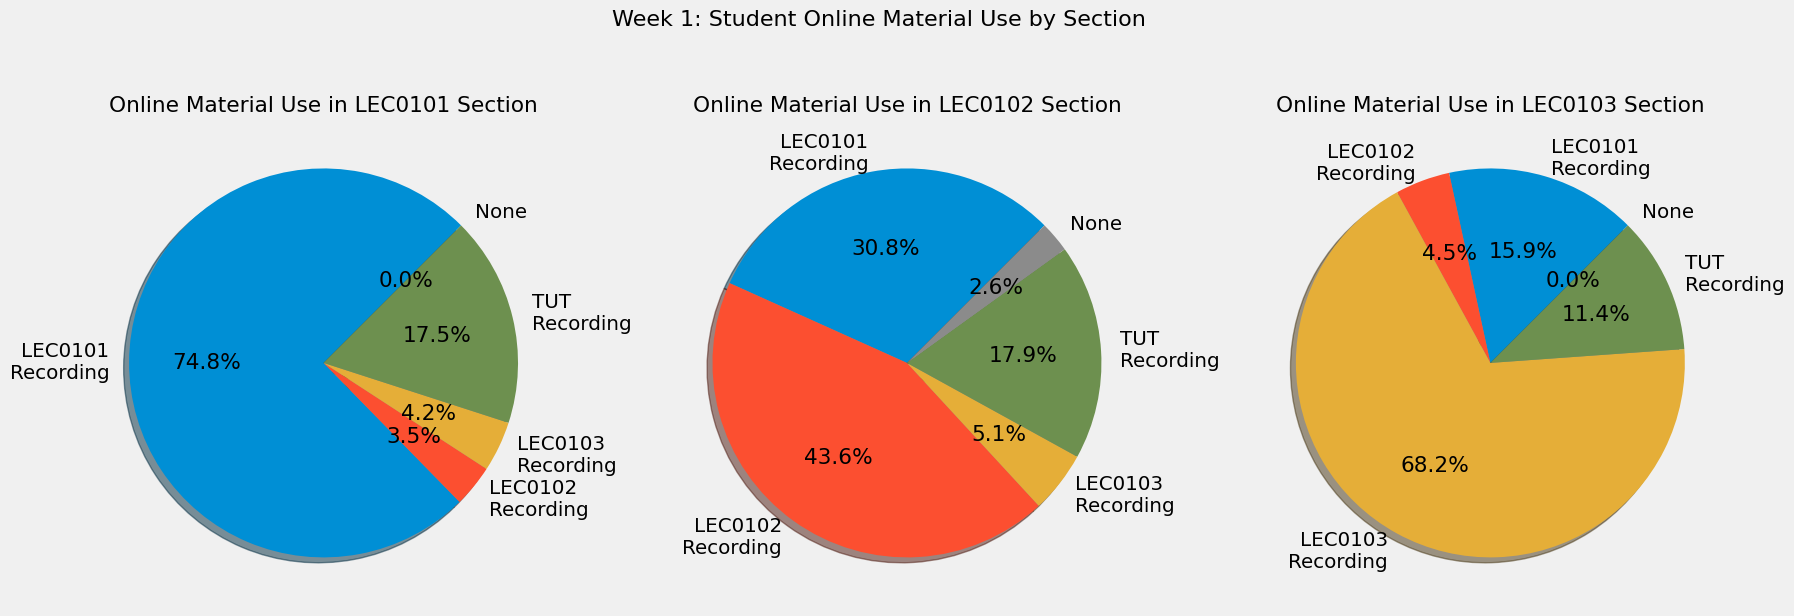

In [202]:
# which video materials are people using per lecture section

fig, axs = plt.subplots(1, 3, figsize=(19, 7))

fig.suptitle("Week {}: Student Online Material Use by Section".format(week), size =16)

# which video materials are people using?
online_values = [
    'LEC0101 - Kinsella & Goodfellow Lecture Recording',
    'LEC0102 - Moosavi Lecture Recording',
    'LEC0103 - Beck Lecture Recording',
    'TUT - Tutorial Recording',
    'None'
]

online_labels = [
    'LEC0101\nRecording',
    'LEC0102\nRecording',
    'LEC0103\nRecording',
    'TUT\nRecording',
    'None'
]

lecture_sections = ['LEC0101', 'LEC0102', 'LEC0103']

for index, lecture in enumerate(lecture_sections): # we will check against assigned lecture sections

    temp_df = combined_df[combined_df['Lecture']==lecture]

    online_count = []

    for value in online_values:
        count = temp_df['video_materials'].str.contains(value)
        count = count.sum()
        online_count.append(count)

    axs[index].pie(online_count, labels = online_labels, autopct='%1.1f%%', shadow=True, startangle=45)
    axs[index].title.set_text("Online Material Use in {} Section".format(str(lecture_list[index])))
  
plt.show()

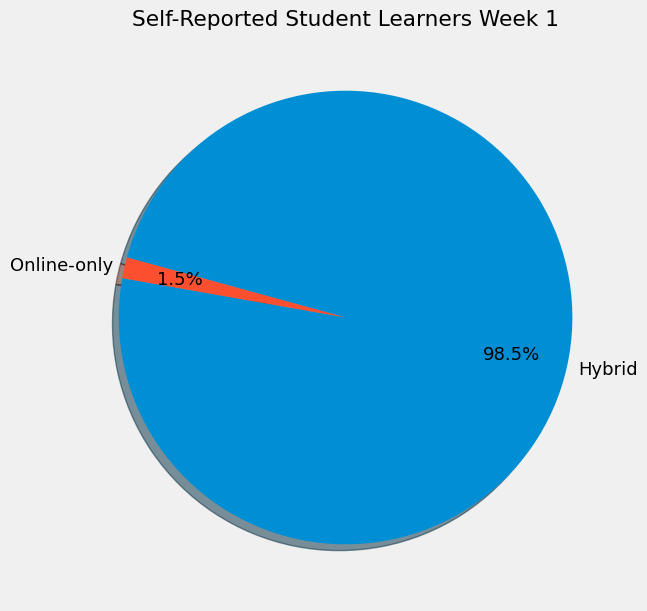

In [203]:
# how many people using video materials also attended lectures in-person
combined_df['lecture_count'] = combined_df['lecture_count'].fillna(0)

# create a column, which will have the values online-only, in-person only or hybrid learner, or no engagement in a given week
combined_df['learner_style'] = np.where(
    (combined_df['video_materials'] != 'None') & (combined_df['lecture_count'] != 0), 'Hybrid',
    np.where(
        (combined_df['video_materials'] == 'None') & (combined_df['lecture_count'] != 0), 'In-Person',
        np.where(
            (combined_df['video_materials'] != 'None') & (combined_df['lecture_count'] == 0), 'Online-only',
            'No engagement this week'
        )
    )
)

plt.figure(figsize=(7,7)) 
plt.title("Self-Reported Student Learners Week {}".format(week))

values = dict(combined_df['learner_style'].value_counts()).values()
labels = dict(combined_df['learner_style'].value_counts()).keys()

plt.pie(values, labels=labels, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.05)

# Change the fontsize of the labels and percentages
plt.setp(plt.gca().texts, fontsize='small')  # Pie chart labels and percentages font size

plt.show()

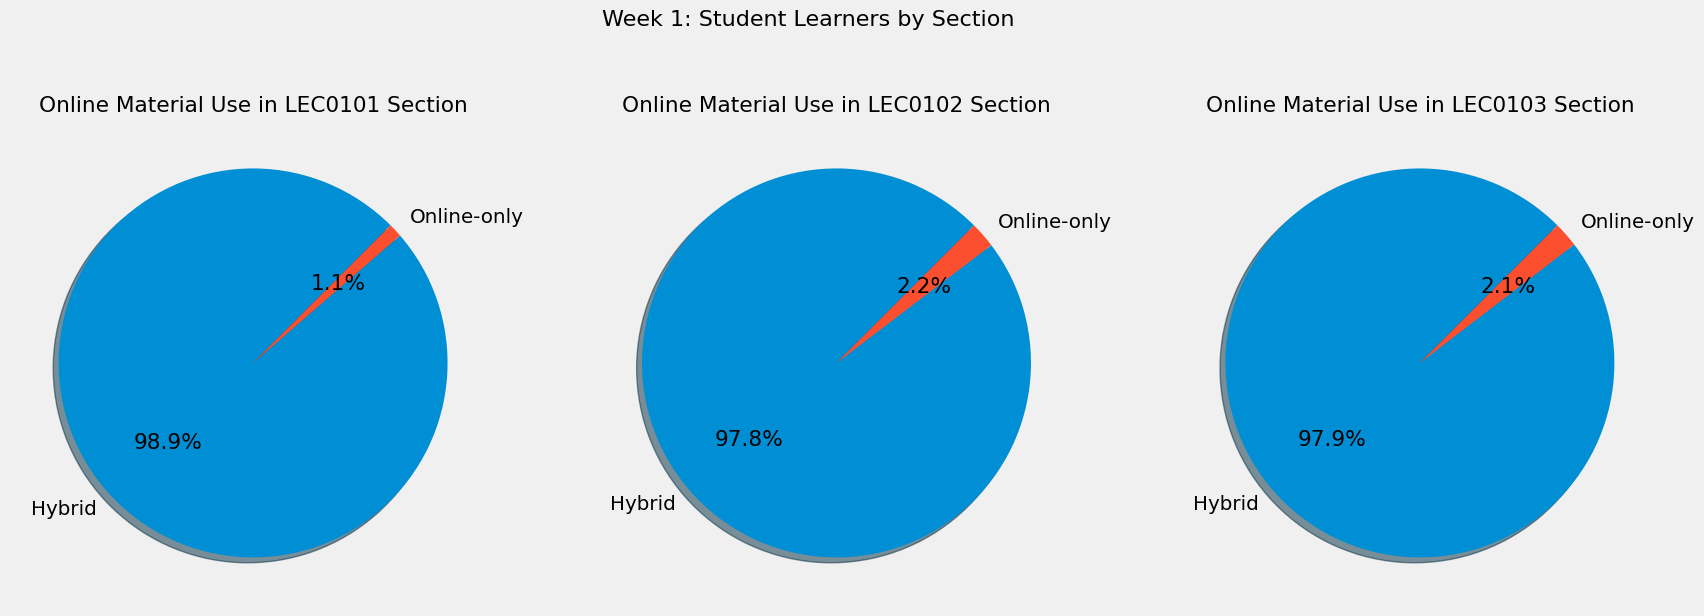

In [204]:
# same as above, but display the result per lecture section
fig, axs = plt.subplots(1, 3, figsize=(19, 7))

fig.suptitle("Week {}: Student Learners by Section".format(week), size =16)

for index, lecture in enumerate(lecture_sections): # we will check against assigned lecture sections

    temp_df = combined_df[combined_df['Lecture']==lecture]

    values = dict(temp_df['learner_style'].value_counts()).values()
    labels = dict(temp_df['learner_style'].value_counts()).keys()

    axs[index].pie(values, labels = labels, autopct='%1.1f%%', shadow=True, startangle=45)
    axs[index].title.set_text("Online Material Use in {} Section".format(str(lecture_list[index])))
  
plt.show()

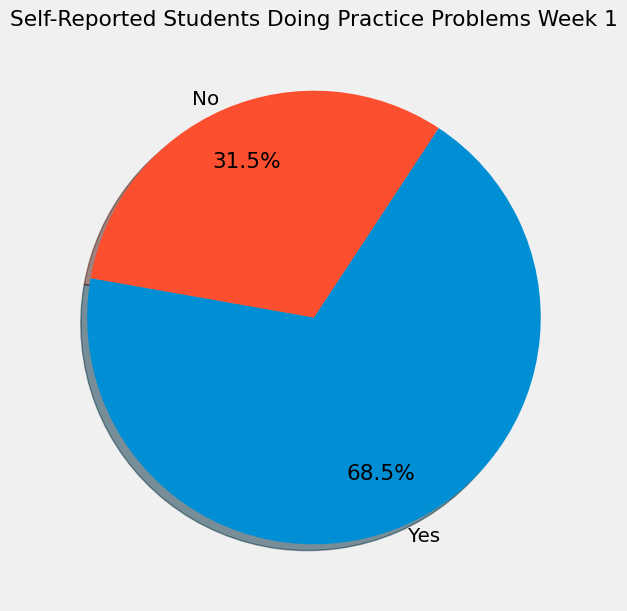

In [205]:
# practice problems
plt.figure(figsize=(7,7)) 
plt.title("Self-Reported Students Doing Practice Problems Week {}".format(week))

values = dict(combined_df['practice_problems'].value_counts()).values()
labels = dict(combined_df['practice_problems'].value_counts()).keys()

plt.pie(values, labels=labels, startangle=-190,autopct='%1.1f%%', shadow=True, pctdistance=0.75, labeldistance=1.05)

plt.show()

# List of Topics Students are Confused With

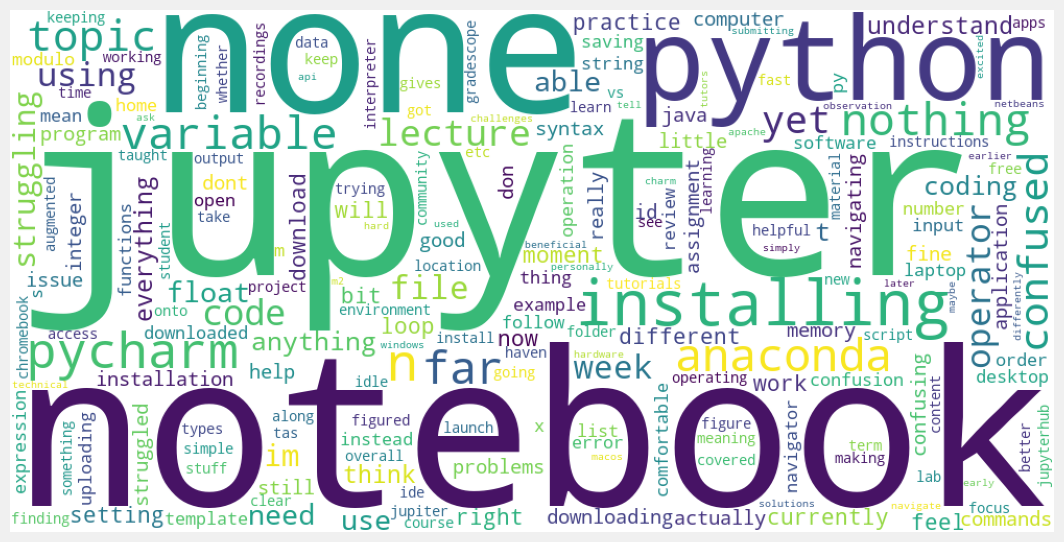

In [206]:
#a word cloud is generated to show the most frequently appearing words
word_text = str((combined_df['confused_topics'].values))
word_text = word_text.lower()

#remove extra characters
extra_chars = ["xa0","\n","'","nan",]

for char in extra_chars:
    word_text = word_text.replace(char,"")

# define word cloud
stopwords = set(STOPWORDS)
confused_topics_words = WordCloud(stopwords=stopwords, background_color="white", collocations=False, width=1000, height=500).generate(word_text)
plt.figure(figsize=(12,8))
plt.imshow(confused_topics_words)
plt.axis("off")

plt.show()

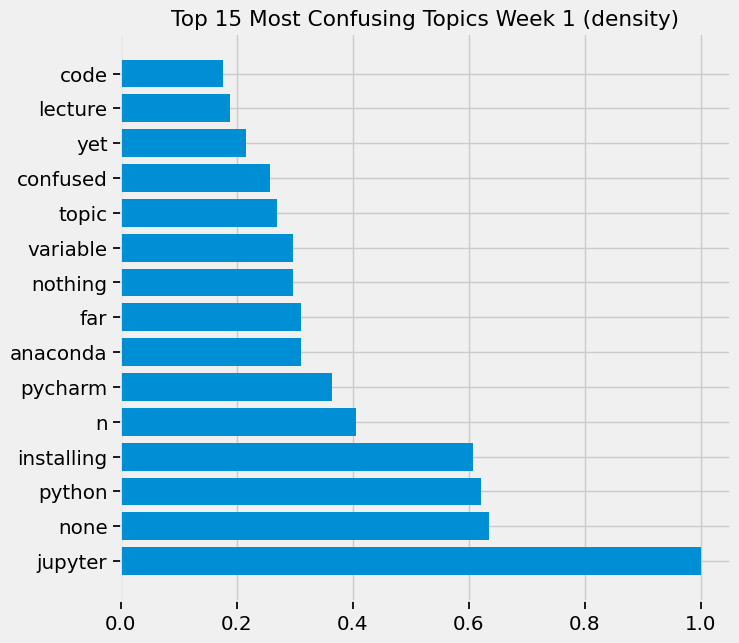

In [207]:
# how many students attended more than one instructor session last week (i.e. both Kinsella and Rosu lectures)
plt.figure(figsize=(7,7)) 
plt.title("Top 15 Most Confusing Topics Week 1 (density)")

name = list(dict(confused_topics_words.words_).keys())[0:1] + list(dict(confused_topics_words.words_).keys())[2:16]
values = list(dict(confused_topics_words.words_).values())[0:1] + list(dict(confused_topics_words.words_).values())[2:16]

plt.barh(name, values)
plt.show()

# Word Cloud: Single Word for How Students are Feeling

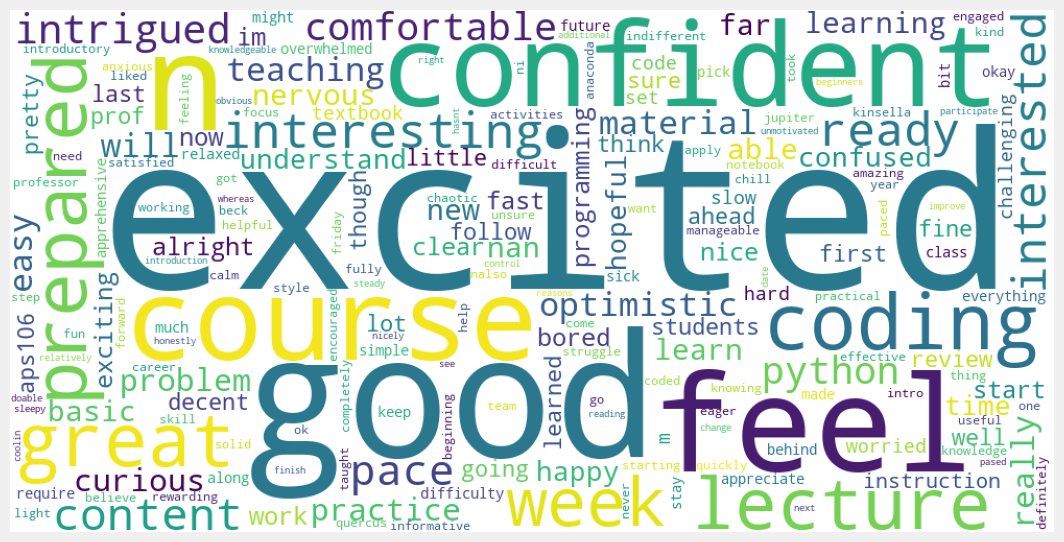

In [208]:
#a word cloud is generated to show the most frequently appearing words
word_text = str((combined_df['comment_one_word'].values))
word_text = word_text.lower()

#remove extra characters
extra_chars = ["xa0","\n","'"]

for char in extra_chars:
    word_text = word_text.replace(char,"")

# define word cloud
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=False, width=1000, height=500).generate(word_text)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

# Sentiment Analysis: Feedback Provided from Students

In [209]:
# describe the observed polarity
combined_df[['polarity']].describe()

polarity
count  470.000000
mean     1.184894
std      1.527560
min     -5.100000
25%      0.000000
50%      1.400000
75%      1.900000
max      9.200000

In [210]:
print("Most positive feedback, Week {}:".format(week))
for text in combined_df.sort_values('polarity').tail(7)['comment_one_word']:
    print('\n  ', text)

Most positive feedback, Week 1:

   Confident and very happy with the teaching style. I took ESC180 last year and was very frustrated with the teaching, and I truly appreciate the instruction and use of simple examples to convey concepts.

   I am excited to learn more about python. I did python in grade 11, but at the time I was not fully interested in it. However, knowing that it can help me out a lot in my future careers, I am definitely more open to learning it now.

   I think this first week is a smooth transition from breaks to the actual lecture materials. I liked the style of teaching and the clear instructions on quercus, which allows me to be clear about deadlines and how to succeed in this course. 

   I feel pretty good. I have coded for around 4 years in Python now, so it was a great chance to revisit basic materials and solidify my understanding of the course materials.

   The contents are inspiring and can provide me with great instructions on the basic logic of python

In [211]:
print("Most negative feedback, Week {}:".format(week))
for text in combined_df.sort_values('polarity').head(6)['comment_one_word']:
    print('\n  ', text)

Most negative feedback, Week 1:

   I feel like I might be at a disadvantage when it comes to other students with previous coding experience. Even though the content so far has been really simple, I fear I might struggle much more due to my lack of programming knowledge. 

   Decent (I was sick this week and had to miss a lecture because of it but I still understand everything that was taught)

   I am excited, but the content is being covered very quickly and that scares me a bit. By the last lecture on Friday, the lecture content surpassed where I reached in the textbook despite me trying to stay one class ahead in my own preparation. Seeing that coding will require practice, I do foresee myself falling behind quickly once the semester workload picks up and lecture content continues at this pace.  So though I am very interested to learn, I am fearful about not being able to keep up, not because of difficulty but pace. 

To be clear, the lectures move at a reasonable pace, but in conj

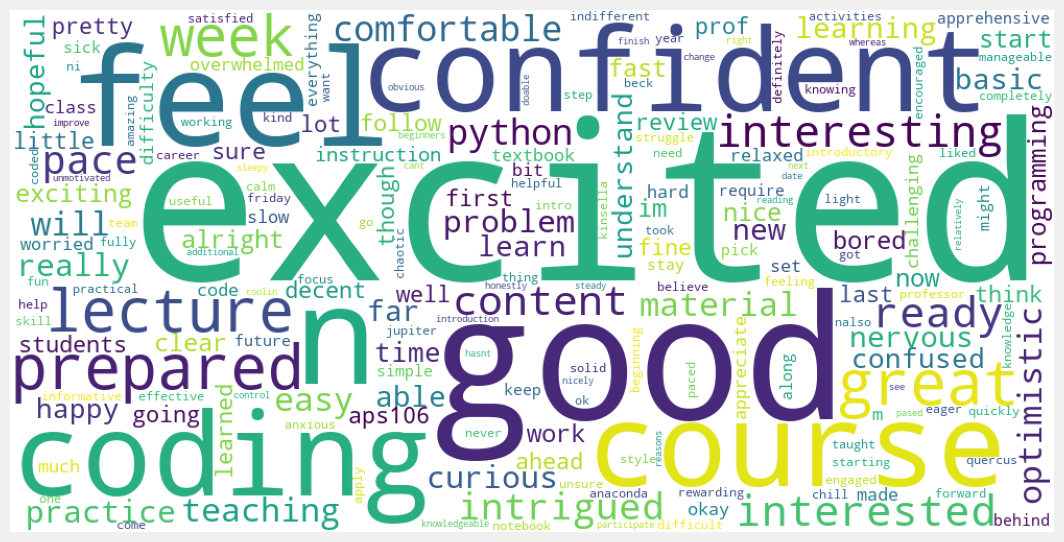

In [212]:
#a word cloud is generated to show the most frequently appearing words
word_text = str((combined_df['comment_one_word'].values))
word_text = word_text.lower()

#remove extra characters
extra_chars = ["xa0","\n","'","nan"]

for char in extra_chars:
    word_text = word_text.replace(char,"")

# define word cloud
stopwords = set(STOPWORDS)
long_answer_words = WordCloud(stopwords=stopwords, background_color="white", collocations=False, width=1000, height=500).generate(word_text)
plt.figure(figsize=(12,8))
plt.imshow(long_answer_words)
plt.axis("off")

plt.show()

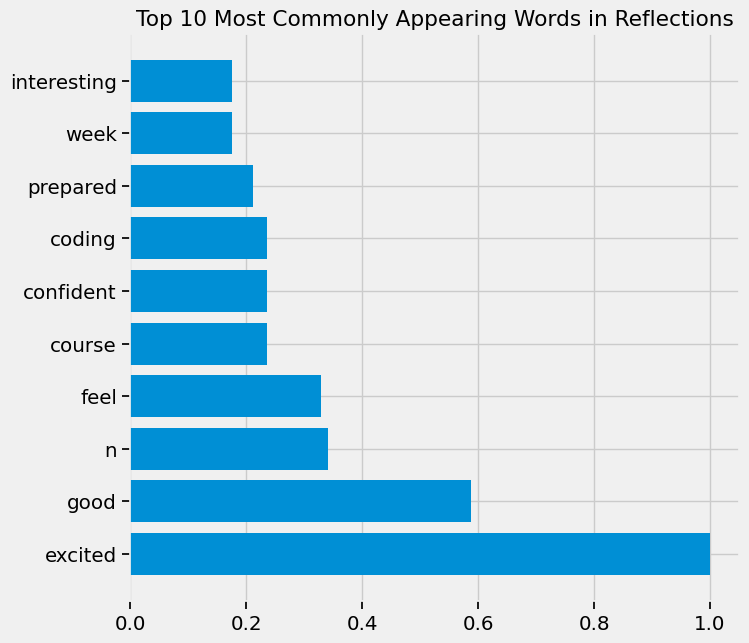

In [213]:
# how many students attended more than one instructor session last week (i.e. both Kinsella and Rosu lectures)
plt.figure(figsize=(7,7)) 
plt.title("Top 10 Most Commonly Appearing Words in Reflections")

name = list(dict(long_answer_words.words_).keys())[0:8] + list(dict(long_answer_words.words_).keys())[10:12]
values = list(dict(long_answer_words.words_).values())[0:8] + list(dict(long_answer_words.words_).values())[10:12]

plt.barh(name, values)
plt.show()

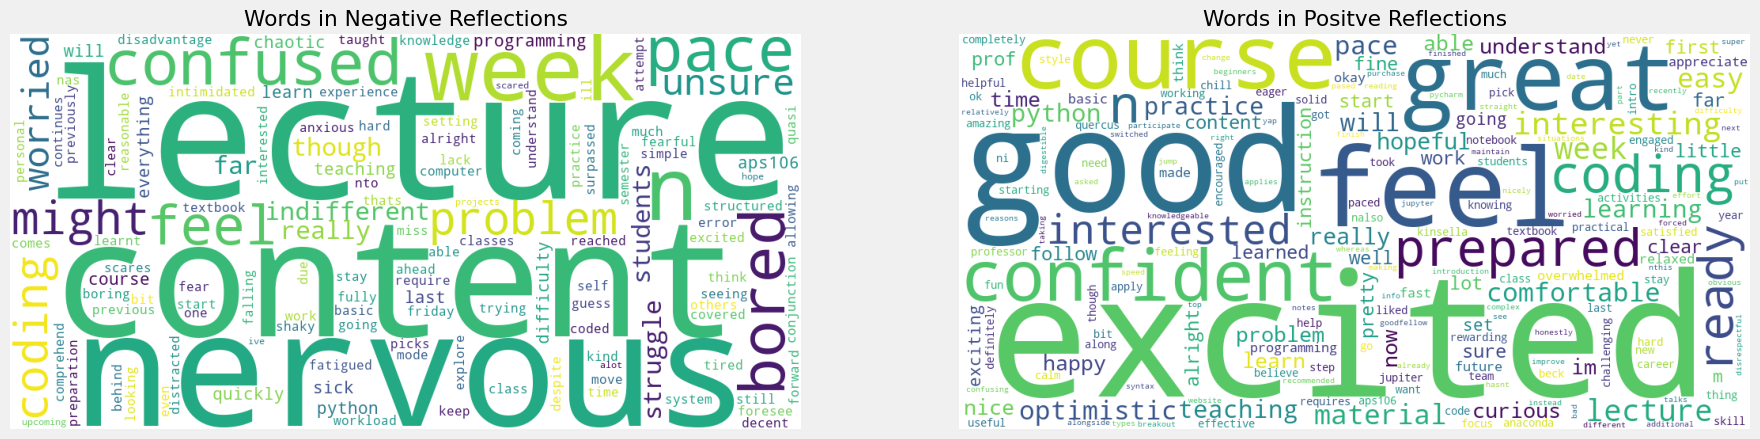

In [214]:
# most commonly appearing words in different polarity reflections
filt = [combined_df[combined_df['polarity']<0], combined_df[combined_df['polarity']>0]]
title = ["Words in Negative Reflections", "Words in Positve Reflections"]

fig, ax = plt.subplots(1,2, figsize=(20, 20))

for index, df in enumerate(filt): 

    word_text = str((df['comment_one_word'].values))
    word_text = word_text.lower()

    #remove extra characters
    extra_chars = ["xa0","\n","'","nan"]

    for char in extra_chars:
        word_text = word_text.replace(char,"")

    # define word cloud
    stopwords = set(STOPWORDS)
    words = WordCloud(stopwords=stopwords, background_color="white", collocations=False, width=1000, height=500).generate(word_text)
    ax[index].imshow(words)
    ax[index].set_title("{}".format(title[index]))
    ax[index].axis("off")

plt.show()
